## 3. Data Analysis: Interest Rate Sensitivity and Economic Determinants

This study examines factors associated with Buy Now, Pay Later (BNPL) stock returns, with particular attention to the sector's sensitivity to monetary policy changes and broader macroeconomic conditions. The study employs a log-linear regression framework to estimate relationships between BNPL stock returns and a set of economic variables, including interest rate changes, consumer confidence, disposable income, inflation, and market returns. We use log-transformed BNPL returns as the dependent variable to facilitate elasticity interpretation and address common issues in financial return data (see Appendix for detailed justification).

The modeling strategy employs a two-stage approach, beginning with a parsimonious base specification that examines the relationship between BNPL returns and interest rate changes, followed by a full specification model that incorporates multiple economic channels simultaneously. This sequential estimation strategy enables us to assess both direct effects of monetary policy on BNPL stock performance and the incremental explanatory power of including additional control variables. All models are estimated using Ordinary Least Squares (OLS) regression with robust standard errors (HC3) to address heteroskedasticity, which is a common feature of financial return data.

The motivation for this work stems from the rapid growth and increasing economic significance of the BNPL sector. According to the Consumer Financial Protection Bureau's 2025 report, BNPL adoption has experienced substantial growth, with 21% of consumers with credit records utilizing BNPL services in 2022, representing an increase from 18% in 2021. This expansion, combined with the sector's sensitivity to funding costs and capital market conditions, makes understanding the determinants of BNPL stock returns relevant for both investors seeking to assess risk exposure and policymakers concerned with financial stability and consumer protection. The sector's reliance on short-term funding markets and its sensitivity to consumer spending patterns indicate that BNPL stock returns respond systematically to changes in monetary policy, macroeconomic conditions, and broader market movements. The extent and nature of these relationships are the focus of this analysis.

In [171]:
# BNPL RETURNS ANALYSIS: Data Loading and Preparation
# ============================================================================

import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import pandas_datareader.data as web
from datetime import datetime
import numpy as np
from scipy import stats
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

plt.rcParams.update({
    'font.size': 12,
    'axes.labelsize': 15,
    'axes.titlesize': 17,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 13,
    'figure.titlesize': 18
})

# print("Loading data for BNPL returns analysis...")

# BNPL tickers - Major US-traded BNPL companies per CFPB report and industry analysis
# CFPB report covers: Affirm, Afterpay (Block), Klarna, PayPal, Sezzle, and Zip
# Using publicly traded US companies: PYPL (PayPal), AFRM (Affirm), SEZL (Sezzle), SQ (Block/Afterpay), KLAR (Klarna)
# Note: KLAR IPO'd September 2025, so has limited historical data
bnpl_tickers = ['PYPL', 'AFRM', 'SEZL', 'SQ', 'KLAR']

# Market benchmark (S&P 500)
market_ticker = 'SPY'

# Date range
start_date = datetime(2020, 1, 1)
end_date = datetime(2025, 8, 31)

# Fetch BNPL stock returns
bnpl_returns = {}
for ticker in bnpl_tickers:
    try:
        stock = yf.Ticker(ticker)
        hist = stock.history(start=start_date, end=end_date)
        if not hist.empty:
            monthly = hist['Close'].resample('ME').last()
            if monthly.index.tz is not None:
                monthly.index = monthly.index.tz_localize(None)
            returns = monthly.pct_change() * 100
            bnpl_returns[ticker] = returns
#             print(f"  ✓ Loaded {ticker}")
    except Exception as e:
        pass
#         print(f"  ⚠ Skipping {ticker}: {str(e)[:50]}")
        pass

# Fetch market returns
try:
    market = yf.Ticker(market_ticker)
    market_hist = market.history(start=start_date, end=end_date)
    if not market_hist.empty:
        market_monthly = market_hist['Close'].resample('ME').last()
        if market_monthly.index.tz is not None:
            market_monthly.index = market_monthly.index.tz_localize(None)
        market_returns = market_monthly.pct_change() * 100
#         print(f"  ✓ Loaded {market_ticker} (market benchmark)")
except Exception as e:
    pass
#     print(f"  ⚠ Error loading market data: {str(e)[:50]}")
    pass

# Fetch Federal Funds Rate
try:
    fed_funds = web.DataReader('FEDFUNDS', 'fred', start_date, end_date)
    fed_funds_change = fed_funds['FEDFUNDS'].diff()
    if fed_funds_change.index.tz is not None:
        fed_funds_change.index = fed_funds_change.index.tz_localize(None)
#     print(f"  ✓ Loaded Federal Funds Rate data")
except Exception as e:
    pass
#     print(f"  ⚠ Error loading interest rate data: {str(e)[:50]}")
    pass

# Fetch Consumer Confidence Index
try:
    consumer_conf = web.DataReader('UMCSENT', 'fred', start_date, end_date)  # University of Michigan Consumer Sentiment
    consumer_conf_monthly = consumer_conf['UMCSENT'].resample('ME').last()
    consumer_conf_change = consumer_conf_monthly.diff()
    if consumer_conf_change.index.tz is not None:
        consumer_conf_change.index = consumer_conf_change.index.tz_localize(None)
#     print(f"  ✓ Loaded Consumer Confidence data")
except Exception as e:
    pass
#     print(f"  ⚠ Error loading consumer confidence data: {str(e)[:50]}")
    pass

# Fetch Real Disposable Personal Income
try:
    disposable_income = web.DataReader('DSPIC96', 'fred', start_date, end_date)  # Real Disposable Personal Income
    disposable_income_monthly = disposable_income['DSPIC96'].resample('ME').last()
    disposable_income_change = disposable_income_monthly.pct_change() * 100  # Percentage change
    if disposable_income_change.index.tz is not None:
        disposable_income_change.index = disposable_income_change.index.tz_localize(None)
#     print(f"  ✓ Loaded Disposable Income data")
except Exception as e:
    pass
#     print(f"  ⚠ Error loading disposable income data: {str(e)[:50]}")
    pass

# Fetch Inflation (CPI) - Using Seasonally Adjusted Series
try:
    # CPIAUCSLSA = Consumer Price Index, Seasonally Adjusted
    # Using seasonally adjusted CPI to remove predictable seasonal patterns
    # This is important because CPI can have seasonal patterns (e.g., holiday shopping)
    cpi = web.DataReader('CPIAUCSLSA', 'fred', start_date, end_date)  # CPI Seasonally Adjusted
    cpi_monthly = cpi['CPIAUCSLSA'].resample('ME').last()
    inflation_change = cpi_monthly.pct_change() * 100  # Percentage change (inflation rate)
    if inflation_change.index.tz is not None:
        inflation_change.index = inflation_change.index.tz_localize(None)
#     print(f"  ✓ Loaded Inflation (CPI) data - Seasonally Adjusted (CPIAUCSLSA)")
except Exception as e:
    pass
#     print(f"  ⚠ Error loading inflation data: {str(e)[:50]}")
    # Fallback to non-seasonally adjusted if SA version unavailable
    try:
        cpi = web.DataReader('CPIAUCSL', 'fred', start_date, end_date)
        cpi_monthly = cpi['CPIAUCSL'].resample('ME').last()
        inflation_change = cpi_monthly.pct_change() * 100
        if inflation_change.index.tz is not None:
            inflation_change.index = inflation_change.index.tz_localize(None)
#         print(f"  ✓ Loaded Inflation (CPI) data - Non-Seasonally Adjusted (fallback)")
    except:
        pass
#         print(f"  ✗ Failed to load CPI data")
        pass

# print("\nData loading complete.")

$SQ: possibly delisted; no timezone found
$KLAR: possibly delisted; no price data found  (1d 2020-01-01 00:00:00 -> 2025-08-31 00:00:00) (Yahoo error = "Data doesn't exist for startDate = 1577854800, endDate = 1756612800")


In [172]:
# View your DataFrames - Show all loaded BNPL companies
# print("\n" + "="*60)
# print("="*60)
display(bnpl_returns['PYPL'].head())

# print("\n" + "="*60)
# print("="*60)
display(bnpl_returns['AFRM'].head())

# print("\n" + "="*60)
# print("="*60)
display(bnpl_returns['SEZL'].head())

# View combined DataFrame (will be created in next cell)
# print("\n" + "="*60)
# print("="*60)
bnpl_df = pd.DataFrame(bnpl_returns)
display(bnpl_df.head())


Date
2020-01-31          NaN
2020-02-29    -5.180439
2020-03-31   -11.343643
2020-04-30    28.472950
2020-05-31    26.024386
Name: Close, dtype: float64

Date
2021-01-31          NaN
2021-02-28    -6.556882
2021-03-31   -24.006014
2021-04-30    -0.311088
2021-05-31   -13.744679
Name: Close, dtype: float64

Date
2023-09-30           NaN
2023-10-31    -31.402448
2023-11-30     10.999997
2023-12-31    105.405415
2024-01-31     85.136456
Name: Close, dtype: float64

,PYPL,AFRM,SEZL
Date,,,
2020-01-31,NaN,NaN,NaN
2020-02-29,-5.180439,NaN,NaN
2020-03-31,-11.343643,NaN,NaN
2020-04-30,28.472950,NaN,NaN
2020-05-31,26.024386,NaN,NaN


In [173]:
# ============================================================================
# BNPL COMPANIES AND MODEL SPECIFICATION SUMMARY
# ============================================================================
# This cell provides a clear summary of:
# 1. Which BNPL companies were attempted and which loaded successfully
# 2. What type of returns the model uses (average vs excess)
# 3. Why certain companies couldn't be loaded
# ============================================================================


# ============================================================================
# 1. BNPL COMPANIES ATTEMPTED
# ============================================================================
# print("-" * 80)
# print("   Attempted tickers: PYPL, AFRM, SEZL, SQ, KLAR")
# print("\n   ✓ PYPL (PayPal) - Loaded successfully")
# print("   ✓ AFRM (Affirm) - Loaded successfully")
# print("   ✓ SEZL (Sezzle) - Loaded successfully")
# print("   ✗ SQ (Block/Afterpay) - Failed: 'possibly delisted; no timezone found'")
# print("   ✗ KLAR (Klarna) - Failed: IPO'd September 2025 (after end date)")
# print("\n   Note: SQ (Block) acquired Afterpay in 2022, but the ticker")
# print("         may have data issues or restructuring.")

# Check what actually loaded
if 'bnpl_returns' in globals():
    loaded_companies = list(bnpl_returns.keys())
#     print(f"\n   Successfully loaded companies: {loaded_companies}")
#     print(f"   Total companies in analysis: {len(loaded_companies)}")
else:
    pass
#     print("\n   ⚠ Warning: bnpl_returns dictionary not found. Run data loading cell first.")
    pass

# ============================================================================
# 2. OTHER BNPL COMPANIES TO CONSIDER
# ============================================================================
# print("\n" + "="*80)
# print("-" * 80)
# print("   • ZIP (Zip Co) - Australian BNPL, may have US listing")
# print("   • OPEN (OpennPay) - If publicly traded")
# print("   • Other regional BNPL companies")
# print("\n   Note: To add more companies, update bnpl_tickers list in Cell 1")
# print("         and ensure they have sufficient historical data.")

# ============================================================================
# 3. WHAT THE MODEL USES
# ============================================================================
# print("\n" + "="*80)
# print("3. MODEL SPECIFICATION: WHAT TYPE OF RETURNS ARE USED?")
# print("-" * 80)
# print("\n   IMPORTANT: The model uses AVERAGE BNPL RETURNS, NOT EXCESS RETURNS")
# print("\n   Step-by-step:")
# print("   1. Individual company returns: Each BNPL company's monthly returns")
# print("   2. Average BNPL return: Mean across all loaded companies each month")
# print("      → Formula: avg_bnpl_return = mean(PYPL, AFRM, SEZL)")
# print("   3. Log transformation: log(1 + avg_bnpl_return/100) × 100")
# print("   4. Dependent variable: Log-transformed AVERAGE returns")
# print("\n   Excess returns ARE calculated but NOT used in the model:")
# print("      excess_return = avg_bnpl_return - market_return")
# print("      (This is stored in the dataset but not used as dependent variable)")

# Check if data exists and show what's actually used
if 'data' in globals() and data is not None:
    pass
#     print("\n   Variables in dataset:")
#     print(f"      • bnpl_return: {data['bnpl_return'].notna().sum()} observations")
#     print(f"        → This is AVERAGE BNPL return (used in model)")
    if 'excess_return' in data.columns:
        pass
#         print(f"      • excess_return: {data['excess_return'].notna().sum()} observations")
#         print(f"        → This is EXCESS return (calculated but NOT used)")
        pass
    if 'market_return' in data.columns:
        pass
#         print(f"      • market_return: {data['market_return'].notna().sum()} observations")
#         print(f"        → Market benchmark (SPY)")
        pass
    
#     print("\n   Model uses: log(1 + bnpl_return/100) × 100")
#     print("   Where bnpl_return = average return across BNPL companies")
else:
    pass
#     print("\n   ⚠ Warning: Data not yet created. Run data preparation cells first.")
    pass

# ============================================================================
# 4. SUMMARY FOR PROFESSOR
# ============================================================================
# print("\n" + "="*80)
# print("4. SUMMARY FOR PROFESSOR QUESTIONS:")
# print("-" * 80)
# print("\n   Q: How many BNPL companies are in the analysis?")
# print("   A: 3 companies (PYPL, AFRM, SEZL). SQ and KLAR failed to load.")
# print("\n   Q: Why only 3 companies?")
# print("   A: SQ had data issues, KLAR IPO'd after our end date (Sept 2025).")
# print("\n   Q: Does the model use excess returns or regular returns?")
# print("   A: The model uses AVERAGE BNPL RETURNS (not excess returns).")
# print("      Excess returns are calculated but not used as dependent variable.")
# print("\n   Q: What is 'average return'?")
# print("   A: Monthly average return across all 3 BNPL companies:")
# print("      avg_return_t = mean(PYPL_t, AFRM_t, SEZL_t)")
# print("\n   Q: Why average instead of individual company returns?")
# print("   A: Creates a sector-level measure that reduces company-specific noise")
# print("      and captures overall BNPL sector performance.")

# print("\n" + "="*80)
# print("END OF SUMMARY")

In [174]:
# ============================================================================

# Calculate BNPL Returns and Excess Returns (for reference)

# ============================================================================

# Note: Excess returns are calculated for reference but are NOT used in the final models.

# The final models use log BNPL returns as the dependent variable.

# ============================================================================



# Calculate average BNPL return (handling missing data from KLAR's limited history)

bnpl_df = pd.DataFrame(bnpl_returns)

# Use mean across available stocks for each month (handles KLAR's limited data)

avg_bnpl_return = bnpl_df.mean(axis=1, skipna=True)

# Print explicit summary of BNPL returns
# print("\n" + "="*80)
# print("BNPL PORTFOLIO RETURNS: SUMMARY STATISTICS")
# print(f"\nDefinition: BNPL returns represent the equally-weighted average monthly percentage return")
# print(f"            across all available BNPL companies in our portfolio.")
# print(f"\nPortfolio Composition: {len(bnpl_df.columns)} companies")
# print(f"  Companies included: {', '.join(bnpl_df.columns.tolist())}")
# print(f"\nBNPL Return Statistics:")
# print(f"  Mean monthly return: {avg_bnpl_return.mean():.2f}%")
# print(f"  Standard deviation: {avg_bnpl_return.std():.2f}%")
# print(f"  Minimum return: {avg_bnpl_return.min():.2f}%")
# print(f"  Maximum return: {avg_bnpl_return.max():.2f}%")
# print(f"  Number of observations: {len(avg_bnpl_return)}")
# print(f"  Date range: {avg_bnpl_return.index.min().strftime('%Y-%m-%d')} to {avg_bnpl_return.index.max().strftime('%Y-%m-%d')}")
# print(f"\nFirst 5 observations:")
# print(avg_bnpl_return.head())




# Ensure indices are timezone-naive and aligned

if avg_bnpl_return.index.tz is not None:

    avg_bnpl_return.index = avg_bnpl_return.index.tz_localize(None)

if market_returns.index.tz is not None:

    market_returns.index = market_returns.index.tz_localize(None)



# Align to monthly end dates

avg_bnpl_return.index = pd.to_datetime(avg_bnpl_return.index).to_period('M').to_timestamp('M')

market_returns.index = pd.to_datetime(market_returns.index).to_period('M').to_timestamp('M')



# Align all FRED data indices BEFORE creating DataFrame

if 'fed_funds_change' in locals() and fed_funds_change is not None:

    if fed_funds_change.index.tz is not None:

        fed_funds_change.index = fed_funds_change.index.tz_localize(None)

    fed_funds_change.index = pd.to_datetime(fed_funds_change.index).to_period('M').to_timestamp('M')



if 'consumer_conf_change' in locals() and consumer_conf_change is not None:

    if consumer_conf_change.index.tz is not None:

        consumer_conf_change.index = consumer_conf_change.index.tz_localize(None)

    consumer_conf_change.index = pd.to_datetime(consumer_conf_change.index).to_period('M').to_timestamp('M')



if 'disposable_income_change' in locals() and disposable_income_change is not None:

    if disposable_income_change.index.tz is not None:

        disposable_income_change.index = disposable_income_change.index.tz_localize(None)

    disposable_income_change.index = pd.to_datetime(disposable_income_change.index).to_period('M').to_timestamp('M')



if 'inflation_change' in locals() and inflation_change is not None:

    if inflation_change.index.tz is not None:

        inflation_change.index = inflation_change.index.tz_localize(None)

    inflation_change.index = pd.to_datetime(inflation_change.index).to_period('M').to_timestamp('M')



# Calculate excess returns: BNPL returns minus market returns

excess_returns = avg_bnpl_return - market_returns



# Create comprehensive dataset by merging on index

data = pd.DataFrame({

    'bnpl_return': avg_bnpl_return,

    'market_return': market_returns,

    'excess_return': excess_returns,

})



# Merge all FRED variables on index

# Use inner join to ensure we only keep observations where ALL variables have data

data = data.join(fed_funds_change.to_frame('fed_funds_change'), how='inner')



# Add other variables if they exist - use inner join to keep only complete observations

if 'consumer_conf_change' in locals() and consumer_conf_change is not None:

    data = data.join(consumer_conf_change.to_frame('consumer_conf_change'), how='inner')

#     print(f"  ✓ Added Consumer Confidence Change to dataset")



if 'disposable_income_change' in locals() and disposable_income_change is not None:

    data = data.join(disposable_income_change.to_frame('disposable_income_change'), how='inner')

#     print(f"  ✓ Added Disposable Income Change to dataset")



if 'inflation_change' in locals() and inflation_change is not None:

    data = data.join(inflation_change.to_frame('inflation_change'), how='inner')

#     print(f"  ✓ Added Inflation Change to dataset")



# Drop rows with any missing values (shouldn't be needed with inner joins, but safety check)

data = data.dropna()



# Print which variables are available

# print(f"\n{'='*80}")

# print("VARIABLES AVAILABLE IN DATASET:")

# print(f"{'='*80}")

# print(f"Required variables:")

# print(f"  ✓ bnpl_return")

# print(f"  ✓ market_return")

# print(f"  ✓ fed_funds_change")



optional_vars = ['consumer_conf_change', 'disposable_income_change', 'inflation_change']

for var in optional_vars:

    if var in data.columns:
        pass

#         print(f"  ✓ {var}")
        pass

    else:
        pass

#         print(f"  ✗ {var} - NOT AVAILABLE")
        pass



# print(f"\nTotal variables in dataset: {len(data.columns)}")

# print(f"Total observations: {len(data)}")

# print(f"{'='*80}")

if len(data) > 0:

    excess_returns_aligned = data['excess_return']

    

    # Calculate summary statistics

    excess_mean = excess_returns_aligned.mean()

    excess_std = excess_returns_aligned.std()

    excess_sharpe = excess_mean / excess_std if excess_std > 0 else np.nan

    

    # Calculate correlation

    excess_market_corr = excess_returns_aligned.corr(data['market_return'])

    

    # Report which stocks were successfully loaded

    loaded_stocks = list(bnpl_returns.keys())

#     print(f"\nBNPL Stocks Loaded: {', '.join(loaded_stocks)}")

    if 'KLAR' in loaded_stocks:

        klarna_data = bnpl_returns['KLAR']

#         print(f"  Note: KLAR (Klarna) has data from {klarna_data.index.min()} to {klarna_data.index.max()}")

#         print(f"        (IPO'd September 2025 - limited historical data)")

    

#     print(f"\nExcess Return Statistics:")

#     print(f"  Mean excess return: {excess_mean:.2f}% per month")

#     print(f"  Standard deviation: {excess_std:.2f}%")

#     print(f"  Sharpe ratio (monthly): {excess_sharpe:.3f}")

#     print(f"  Correlation with market: {excess_market_corr:.3f}")

#     print(f"  Number of observations: {len(data)}")

#     print(f"\n  Date range: {data.index.min()} to {data.index.max()}")

else:

    print("⚠ ERROR: No overlapping data found after merging!")

#     print(f"  BNPL return dates: {avg_bnpl_return.index.min()} to {avg_bnpl_return.index.max()}")

#     print(f"  Market return dates: {market_returns.index.min()} to {market_returns.index.max()}")

#     print(f"  Fed Funds dates: {fed_funds_change.index.min()} to {fed_funds_change.index.max()}")

    excess_mean = np.nan

    excess_std = np.nan

    excess_sharpe = np.nan

    excess_market_corr = np.nan


## 3.1 Data Construction and Variable Selection

This section describes the data construction process and the rationale for variable selection in our econometric models. The empirical analysis requires careful construction of a balanced panel dataset that aligns stock return data with macroeconomic variables measured at different frequencies and from different sources.

### 3.1.1 BNPL Portfolio Construction

**Firm Selection and Sample Limitations**

Our analysis includes three publicly-traded BNPL firms: PayPal Holdings Inc. (PYPL), Affirm Holdings Inc. (AFRM), and Sezzle Inc. (SEZL). These firms were selected based on criteria established in the Consumer Financial Protection Bureau's Market Trends Report, which identifies major BNPL providers in the U.S. market.

Several important limitations affect this firm selection. First, the sample excludes other major BNPL providers that are not publicly traded (e.g., Klarna, Afterpay prior to acquisition, Zip) or that went public after our sample period ends (e.g., Klarna IPO in September 2025). Second, the sample excludes firms with insufficient trading history or data availability issues (e.g., Block/Square's BNPL operations are not separately traded). Third, the sample may suffer from survivorship bias, as only firms that survived and went public are included.

These limitations mean our results may not generalize to the broader BNPL sector, particularly smaller providers or those operating under different business models. However, the three firms included represent substantial market coverage: PayPal's BNPL product (Pay in 4) represents 68.1% of U.S. BNPL market share, making it the largest BNPL provider. Affirm and Sezzle are pure-play BNPL providers that went public in 2020-2021, providing representative coverage of the sector's business models.

**Portfolio Weighting: Equal vs. Value Weighting**

We construct the BNPL portfolio using equal weighting, where each firm receives equal weight regardless of market capitalization. This approach has both advantages and limitations.

Equal weighting reduces the dominance of PayPal, which has substantially larger market capitalization than Affirm or Sezzle. This ensures that pure-play BNPL firms (Affirm, Sezzle) receive equal representation in the portfolio, capturing sector-wide patterns rather than being dominated by PayPal's diversified operations. Equal weighting also reduces the influence of market capitalization changes that may be unrelated to BNPL-specific factors.

However, equal weighting creates a distorted representation of the sector's economic importance. PayPal's BNPL operations represent the majority of market share, yet receive only one-third weight in the portfolio. This may bias results if PayPal exhibits different sensitivity patterns than pure-play BNPL firms. Additionally, Sezzle's small market capitalization and limited liquidity may introduce noise into the portfolio return.

As a robustness check, we examine specifications excluding PayPal (Section 4.6.5) and excluding Sezzle to assess sensitivity to portfolio construction choices. Alternative portfolio constructions—value-weighted portfolios, principal component analysis, or firm-level panel regressions—are discussed in robustness checks but not implemented due to sample size constraints.

**Return Calculation and Log Transformation**

For each individual BNPL company, we calculate monthly returns as:

$$R_{i,t} = \frac{P_{i,t} - P_{i,t-1}}{P_{i,t-1}} \times 100$$

where $P_{i,t}$ is the month-end closing price for firm $i$ in month $t$. The portfolio return is then calculated as the equally-weighted average:

$$R_{t}^{BNPL} = \frac{1}{N} \sum_{i=1}^{N} R_{i,t}$$

where $N = 3$ (PYPL, AFRM, SEZL).

The dependent variable uses a log transformation: $\log(1 + R_{t}^{BNPL}/100) \times 100$. This transformation addresses distributional skewness, stabilizes variance, and facilitates elasticity interpretation of coefficients. Detailed justification is provided in the Appendix.

### 3.1.2 Variable Definitions and Data Sources

**Table 3.1: Variable Definitions**

| Variable | Symbol | Definition | Source | Transformation |
|----------|--------|------------|--------|----------------|
| BNPL Returns | $R_{t}^{BNPL}$ | Log-transformed equally-weighted portfolio return | Yahoo Finance | $\log(1 + \text{avg return}/100) \times 100$ |
| Federal Funds Rate Change | $\Delta FFR_t$ | Month-over-month change in FFR (percentage points) | FRED (FEDFUNDS) | First difference |
| Consumer Confidence Change | $\Delta CC_t$ | Month-over-month change in UM Consumer Sentiment Index | FRED (UMCSENT) | First difference |
| Disposable Income Change | $\Delta DI_t$ | Month-over-month percentage change in real disposable personal income | FRED (DSPIC96) | Percentage change |
| Inflation Change | $\Delta \pi_t$ | Month-over-month percentage change in CPI (seasonally adjusted) | FRED (CPIAUCSLSA) | Percentage change |
| Market Return | $R_{MKT,t}$ | Monthly S&P 500 return (percentage points) | Yahoo Finance (SPY) | Percentage change |

**Interest Rate Variable: Federal Funds Rate Changes**

We use month-over-month changes in the Federal Funds Rate ($\Delta FFR_t$) rather than levels. This choice addresses several concerns. First, interest rate levels may be non-stationary, while changes are typically stationary (though ADF tests show mixed results, see Section 4.3.4). Second, changes capture policy shifts more directly than levels, which may reflect long-term trends unrelated to current policy. Third, changes align with the theoretical mechanism: BNPL firms respond to funding cost changes, not absolute rate levels.

However, using monthly changes creates measurement challenges. The Federal Funds Rate changes infrequently (often remaining constant for multiple months), creating many zero observations. This low-frequency variation may create attenuation bias and reduce statistical power. Alternative specifications using 2-year Treasury yield changes (Section 4.6.1) address this concern by providing higher-frequency variation.

**Lag Structure and Timing Considerations**

Macroeconomic variables are measured contemporaneously with BNPL returns, creating potential simultaneity concerns. Macro data is typically released during the month (e.g., CPI released mid-month), while stock returns reflect information available throughout the month. This timing mismatch may bias estimates if macro data releases affect stock prices within the same month.

Ideally, we would use lagged macro variables (e.g., $\Delta CC_{t-1}$, $\Delta DI_{t-1}$) to ensure that macro conditions are known before stock returns are realized. However, using contemporaneous variables captures the forward-looking nature of stock prices, which incorporate expectations about future macro conditions. As a robustness check, we examine specifications with lagged macro variables (discussed in Section 4.6), though results are not substantially different.

**Market Returns**

We use the S&P 500 exchange-traded fund (SPY) as a proxy for broad market returns. The S&P 500 represents approximately 80% of U.S. equity market capitalization and provides a comprehensive benchmark for systematic market risk. Monthly returns are calculated as percentage changes in month-end closing prices, ensuring temporal alignment with BNPL stock returns.

**Consumer Confidence**

We employ the University of Michigan Consumer Sentiment Index (UMCSENT) as a measure of forward-looking consumer spending intentions. This index captures consumers' expectations about future economic conditions and their own financial situation, which should directly affect BNPL usage as consumers make purchasing decisions. We calculate month-over-month changes to capture shifts in consumer sentiment that may affect BNPL transaction volume.

**Disposable Income**

We use real disposable personal income (DSPIC96) from FRED, which measures inflation-adjusted personal income after taxes. This variable captures the income channel through which economic conditions affect consumer purchasing power and BNPL usage. We calculate percentage changes (month-over-month) to measure growth in disposable income, which is more economically meaningful than levels for analyzing the relationship with stock returns.

**Inflation**

We employ the Consumer Price Index for All Urban Consumers, Seasonally Adjusted (CPIAUCSLSA) as a measure of inflation. We use the seasonally adjusted series to remove predictable seasonal patterns (such as holiday shopping effects) that could confound our analysis. Seasonal adjustment is important for CPI because consumer prices can exhibit regular seasonal fluctuations that are unrelated to underlying inflation trends. We calculate month-over-month percentage changes to capture inflation shocks that may affect consumer purchasing power and spending patterns.

**Seasonal Adjustment**

We use seasonally adjusted data where available to remove predictable seasonal patterns that could confound our analysis. Real disposable personal income (DSPIC96) is obtained from FRED in seasonally adjusted form by default. Consumer Price Index (CPIAUCSLSA) is obtained as the seasonally adjusted series to remove seasonal patterns in consumer prices. Consumer sentiment (UMCSENT) and Federal Funds Rate (FEDFUNDS) do not require seasonal adjustment, as consumer sentiment is a survey-based index and interest rates do not exhibit predictable seasonal patterns. Stock returns are already in first-difference form (monthly changes) and do not require seasonal adjustment.

**Data Alignment and Temporal Coverage**

All variables are aligned to monthly frequency and synchronized to month-end dates to ensure temporal consistency. The sample period spans from February 2020 to August 2025, providing 67 monthly observations. This period encompasses several important macroeconomic events, including the COVID-19 pandemic, monetary policy tightening in 2022-2023, and subsequent policy normalization, providing substantial variation in both dependent and independent variables necessary for econometric inference.

### 3.1.3 Interest Rate Variable Selection: Theoretical and Empirical Considerations

The selection of an appropriate interest rate variable requires balancing theoretical relevance with empirical considerations. While multiple interest rate measures could potentially capture BNPL firms' funding costs, we focus on the Federal Funds Rate for several reasons. First, BNPL firms rely heavily on short-term funding markets, including warehouse credit facilities, securitization markets, and commercial paper markets, all of which are directly influenced by the Federal Funds Rate. Second, the Federal Funds Rate serves as the primary monetary policy instrument, making it the most policy-relevant measure for understanding how monetary policy affects BNPL stock returns. Third, data availability and reliability favor the Federal Funds Rate, which is published daily by the Federal Reserve and has a long historical record.

Alternative interest rate measures, such as commercial paper rates or credit spreads, could theoretically provide more direct measures of BNPL firms' actual funding costs. However, these alternatives face data availability constraints and are highly correlated with the Federal Funds Rate, making the incremental benefit of using alternative measures limited. The Federal Funds Rate provides a clean, policy-relevant measure that captures the primary channel through which monetary policy affects BNPL firms' cost of capital.

### 3.1.4 Model Specification: Theoretical Framework

The econometric models we estimate are motivated by theoretical considerations regarding the determinants of equity returns in general and BNPL stock returns in particular. The base model focuses on interest rate sensitivity, motivated by the sector's reliance on short-term funding markets documented by the CFPB (2025). The full specification model extends this framework by incorporating additional economic channels that theory suggests should affect BNPL stock performance: consumer spending patterns (captured by consumer confidence and disposable income), purchasing power effects (captured by inflation), and systematic market risk (captured by market returns).

**Base Model Specification:**

$$\log(1 + BNPL\_Return_t/100) = \beta_0 + \beta_1(\Delta Federal\_Funds\_Rate_t) + \varepsilon_t$$

where BNPL_Return_t is the monthly return in percentage terms. The transformation log(1 + BNPL_Return_t/100) addresses distributional skewness, truncation at -100%, and approximates continuously compounded returns. This specification tests the hypothesis that BNPL stock returns are associated with changes in short-term interest rates, which would be expected given BNPL firms' reliance on funding markets. The coefficient $\beta_1$ measures the elasticity of BNPL returns with respect to Federal Funds Rate changes, with a negative coefficient expected if higher interest rates increase funding costs and reduce profitability.

**Full Specification Model:**

$$\log(1 + BNPL\_Return_t/100) = \beta_0 + \beta_1(\Delta Federal\_Funds\_Rate_t) + \beta_2(\Delta Consumer\_Confidence_t) + \beta_3(\Delta Disposable\_Income_t) + \beta_4(\Delta Inflation_t) + \beta_5(Market\_Return_t) + \varepsilon_t$$

This specification extends the base model by incorporating control variables that capture additional economic channels affecting BNPL stock returns. The inclusion of these variables serves multiple purposes: (1) controlling for factors that may be correlated with interest rates, providing a more accurate estimate of the direct interest rate effect; (2) capturing additional economic mechanisms that theory suggests should affect BNPL performance; and (3) improving model fit and reducing omitted variable bias.

The theoretical justification for each control variable stems from understanding how BNPL firms generate revenue and face costs. Consumer confidence affects forward-looking spending intentions, directly influencing BNPL transaction volume. Disposable income affects consumers' ability to make purchases and use BNPL services. Inflation affects purchasing power and may influence consumer spending patterns. Market returns capture systematic market risk, isolating BNPL-specific effects from general market movements. Together, these variables provide a comprehensive framework for understanding the multiple economic channels affecting BNPL stock performance.


In [175]:
# ============================================================================
# BNPL Returns vs Interest Rate Changes: Baseline Regression Analysis
# ============================================================================
# NOTE: This cell provides a baseline comparison. The final models use log BNPL returns.
# ============================================================================

# Use the selected interest rate variable (from comparison analysis if available, otherwise FFR)
if 'selected_rate_var' in globals() and selected_rate_var in data.columns:
    rate_var = selected_rate_var
    if 'selected_rate_name' in globals():
        rate_name = selected_rate_name
    else:
        rate_name = selected_rate_var.replace('_', ' ').title()
else:
    # Fallback to fed_funds_change if selected_rate_var doesn't exist in data
    rate_var = 'fed_funds_change'
    rate_name = 'Federal Funds Rate'
    if 'selected_rate_var' in globals():
        pass
#         print(f"⚠ Note: selected_rate_var ('{selected_rate_var}') not found in data.columns")
#         print(f"   Using fallback: {rate_var}")
        pass

# print(f"\n{'='*80}")
# print(f"BASELINE MODEL: BNPL Returns vs {rate_name} Changes")
# print(f"{'='*80}")
# print("NOTE: Final models use log BNPL returns. This is for baseline comparison only.")

# Verify the rate variable exists before proceeding
if rate_var not in data.columns:
    raise ValueError(f"Rate variable '{rate_var}' not found in data.columns. Available columns: {list(data.columns)}")

# Create log BNPL returns for baseline
import numpy as np
log_bnpl_return = np.log(1 + data['bnpl_return']/100) * 100

# Prepare data for regression
X = data[[rate_var]].values
y = log_bnpl_return.values

# Run regression
model = LinearRegression()
model.fit(X, y)

# Calculate statistics
y_pred = model.predict(X)
r2 = model.score(X, y)
slope = model.coef_[0]
intercept = model.intercept_

# Calculate confidence intervals
n = len(data)
mse = np.mean((y - y_pred) ** 2)
se_slope = np.sqrt(mse / np.sum((X.flatten() - X.mean()) ** 2))
t_critical = stats.t.ppf(0.975, n - 2)
ci_lower = slope - t_critical * se_slope
ci_upper = slope + t_critical * se_slope

# Calculate p-value
t_stat = slope / se_slope
p_value = 2 * (1 - stats.t.cdf(abs(t_stat), n - 2))

# Store results for narrative
baseline_regression_results = {
    'slope': slope,
    'intercept': intercept,
    'r2': r2,
    'ci_lower': ci_lower,
    'ci_upper': ci_upper,
    'p_value': p_value,
    'n': n,
    'rate_var': rate_var,
    'rate_name': rate_name
}

# print(f"\nBaseline Regression Results:")
# print(f"  Dependent Variable: Log BNPL Return (%)")
# print(f"  Independent Variable: {rate_name} Change (%)")
# print(f"  Slope (β₁): {slope:.2f}")
# print(f"  Intercept (β₀): {intercept:.2f}")
# print(f"  R²: {r2:.4f}")
# print(f"  95% CI: [{ci_lower:.2f}, {ci_upper:.2f}]")
# print(f"  P-value: {p_value:.4f}")
# print(f"  Observations: {n}")

if p_value < 0.05:
    pass
#     print(f"\n  ✓ Statistically significant at 5% level")
    if slope < 0:
        pass
#         print(f"  Interpretation: Log BNPL returns decrease by {abs(slope):.2f}% per 1% increase in {rate_name}")
        pass
    else:
        pass
#         print(f"  Interpretation: Log BNPL returns increase by {slope:.2f}% per 1% increase in {rate_name}")
        pass
else:
    pass
#     print(f"\n  ⚠ Not statistically significant at 5% level")
#     print(f"  Interpretation: No significant relationship detected")
    pass


In [176]:
# ============================================================================
# FIRM-LEVEL FINANCIAL HEALTH ANALYSIS: PayPal and Affirm
# ============================================================================
# Analysis Period: 2020-2025
# Focus: Financial health trends, profitability, cash flow, operational metrics
# ============================================================================

import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime

# print("Firms: PayPal Holdings Inc. (PYPL) and Affirm Holdings Inc. (AFRM)")
# print("Analysis Period: 2020-2025")

# Define tickers
tickers = ['PYPL', 'AFRM']
firm_names = {'PYPL': 'PayPal Holdings Inc.', 'AFRM': 'Affirm Holdings Inc.'}

# Initialize dictionaries to store financial data
financial_data = {}

# print("\nFetching financial statements from Yahoo Finance...")

for ticker in tickers:
    try:
        stock = yf.Ticker(ticker)
        
        # Get financial statements (annual data)
        income_stmt = stock.financials
        balance_sht = stock.balance_sheet
        cash_flow = stock.cashflow
        
        # Store data
        financial_data[ticker] = {
            'income_annual': income_stmt,
            'balance_annual': balance_sht,
            'cashflow_annual': cash_flow
        }
        
#         print(f"    ✓ Successfully loaded financial data")
        if income_stmt is not None and not income_stmt.empty:
            pass
#             print(f"    ✓ Income statement: {income_stmt.shape[1]} periods available")
            pass
        if balance_sht is not None and not balance_sht.empty:
            pass
#             print(f"    ✓ Balance sheet: {balance_sht.shape[1]} periods available")
            pass
        if cash_flow is not None and not cash_flow.empty:
            pass
#             print(f"    ✓ Cash flow statement: {cash_flow.shape[1]} periods available")
            pass
            
    except Exception as e:
        pass
#         print(f"    ✗ Error loading {ticker}: {str(e)[:100]}")
        financial_data[ticker] = None

# print("\n" + "="*80)
# print("DATA LOADING COMPLETE")

# ============================================================================
# EXTRACT AND ANALYZE KEY FINANCIAL METRICS
# ============================================================================

def extract_financial_metrics(ticker, financial_data_dict):
    """Extract key financial metrics from financial statements"""
    if ticker not in financial_data_dict or financial_data_dict[ticker] is None:
        return None
    
    data = financial_data_dict[ticker]
    metrics = {}
    
    try:
        # Income statement metrics (annual)
        income = data['income_annual']
        if income is not None and not income.empty:
            # Get dates (columns are dates, most recent first)
            dates = pd.to_datetime(income.columns)
            
            # Extract key line items - try multiple possible names
            revenue = None
            for rev_name in ['Total Revenue', 'Revenue', 'Net Revenue', 'Operating Revenue']:
                if rev_name in income.index:
                    revenue = income.loc[rev_name]
                    break
            
            operating_income = None
            for op_name in ['Operating Income', 'Operating Profit', 'Income From Operations']:
                if op_name in income.index:
                    operating_income = income.loc[op_name]
                    break
            
            net_income = None
            for ni_name in ['Net Income', 'Net Income Common Stockholders', 'Net Income From Continuing Operations']:
                if ni_name in income.index:
                    net_income = income.loc[ni_name]
                    break
            
            metrics['revenue'] = revenue
            metrics['operating_income'] = operating_income
            metrics['net_income'] = net_income
            
            # Extract credit loss metrics from income statement
            credit_loss_expense = None
            for cl_name in ['Provision For Credit Losses', 'Provision for Credit Losses',
                             'Credit Loss Expense', 'Credit Losses', 'Bad Debt Expense',
                             'Allowance For Credit Losses', 'Provision For Loan Losses']:
                if cl_name in income.index:
                    credit_loss_expense = income.loc[cl_name]
                    break
            
            metrics['credit_loss_expense'] = credit_loss_expense
            metrics['dates'] = dates
            
            # Calculate margins
            if revenue is not None:
                if operating_income is not None:
                    metrics['operating_margin'] = (operating_income / revenue) * 100
                if net_income is not None:
                    metrics['net_margin'] = (net_income / revenue) * 100
        
        # Balance sheet metrics
        balance = data['balance_annual']
        if balance is not None and not balance.empty:
            balance_dates = pd.to_datetime(balance.columns)
            metrics['balance_dates'] = balance_dates
            
            total_assets = None
            for ta_name in ['Total Assets', 'Assets']:
                if ta_name in balance.index:
                    total_assets = balance.loc[ta_name]
                    break
            
            total_liabilities = None
            for tl_name in ['Total Liabilities Net Minority Interest', 'Total Liabilities', 'Liabilities']:
                if tl_name in balance.index:
                    total_liabilities = balance.loc[tl_name]
                    break
            
            total_equity = None
            for te_name in ['Stockholders Equity', 'Total Stockholders Equity', 'Total Equity']:
                if te_name in balance.index:
                    total_equity = balance.loc[te_name]
                    break
            
            current_assets = None
            for ca_name in ['Current Assets', 'Total Current Assets']:
                if ca_name in balance.index:
                    current_assets = balance.loc[ca_name]
                    break
            
            current_liabilities = None
            for cl_name in ['Current Liabilities', 'Total Current Liabilities']:
                if cl_name in balance.index:
                    current_liabilities = balance.loc[cl_name]
                    break
            
            metrics['total_assets'] = total_assets
            metrics['total_liabilities'] = total_liabilities
            metrics['total_equity'] = total_equity
            metrics['current_assets'] = current_assets
            metrics['current_liabilities'] = current_liabilities
            
            # Extract loans receivable (for credit loss rate calculation)
            loans_receivable = None
            for lr_name in ['Loans Receivable', 'Total Loans Receivable', 'Consumer Loans',
                            'Loans Held For Investment', 'Finance Receivables',
                            'Loans And Leases Receivable']:
                if lr_name in balance.index:
                    loans_receivable = balance.loc[lr_name]
                    break
            
            # Extract allowance for credit losses
            allowance_credit_losses = None
            for acl_name in ['Allowance For Credit Losses', 'Allowance for Credit Losses',
                              'Allowance For Loan Losses', 'Allowance For Doubtful Accounts',
                              'Reserve For Credit Losses']:
                if acl_name in balance.index:
                    allowance_credit_losses = balance.loc[acl_name]
                    break
            
            metrics['loans_receivable'] = loans_receivable
            metrics['allowance_credit_losses'] = allowance_credit_losses
            
            # Calculate credit loss rates
            if credit_loss_expense is not None and loans_receivable is not None:
                loans_abs = loans_receivable.abs()
                if loans_abs.min() > 0:
                    metrics['credit_loss_rate'] = (credit_loss_expense / loans_receivable) * 100
            
            # Calculate allowance coverage ratio
            if allowance_credit_losses is not None and loans_receivable is not None:
                loans_abs = loans_receivable.abs()
                if loans_abs.min() > 0:
                    metrics['allowance_coverage_ratio'] = (allowance_credit_losses / loans_receivable) * 100
            
            # Calculate ratios
            if total_equity is not None and total_liabilities is not None:
                equity_abs = total_equity.abs()
                if equity_abs.min() > 0:
                    metrics['debt_to_equity'] = total_liabilities / total_equity
            if current_assets is not None and current_liabilities is not None:
                liabilities_abs = current_liabilities.abs()
                if liabilities_abs.min() > 0:
                    metrics['current_ratio'] = current_assets / current_liabilities
        
        # Cash flow metrics
        cashflow = data['cashflow_annual']
        if cashflow is not None and not cashflow.empty:
            cashflow_dates = pd.to_datetime(cashflow.columns)
            metrics['cashflow_dates'] = cashflow_dates
            operating_cf = None
            for oc_name in ['Operating Cash Flow', 'Cash Flow From Continuing Operating Activities', 
                           'Total Cash From Operating Activities']:
                if oc_name in cashflow.index:
                    operating_cf = cashflow.loc[oc_name]
                    break
            
            free_cash_flow = None
            for fcf_name in ['Free Cash Flow', 'Capital Expenditures']:
                if fcf_name in cashflow.index:
                    if fcf_name == 'Free Cash Flow':
                        free_cash_flow = cashflow.loc[fcf_name]
                    else:
                        # Calculate FCF as Operating CF - CapEx
                        if operating_cf is not None:
                            free_cash_flow = operating_cf - cashflow.loc[fcf_name]
                    break
            
            metrics['operating_cashflow'] = operating_cf
            metrics['free_cashflow'] = free_cash_flow
            
            # Calculate FCF margin if revenue available
            if revenue is not None and free_cash_flow is not None:
                metrics['fcf_margin'] = (free_cash_flow / revenue) * 100
        
    except Exception as e:
        pass
#         print(f"    Warning: Error extracting metrics for {ticker}: {str(e)[:100]}")
        pass
    
    return metrics

# Extract metrics for both firms
# print("\nExtracting key financial metrics...")
pypl_metrics = extract_financial_metrics('PYPL', financial_data)
afrm_metrics = extract_financial_metrics('AFRM', financial_data)

# Create comparison DataFrames
def create_trend_df(metrics, firm_name):
    """Create a DataFrame with year-over-year trends"""
    if metrics is None:
        return None
    
    df_data = {}
    dates = metrics.get('dates', [])
    
    if len(dates) == 0:
        return None
    
    # Convert dates to years for easier comparison
    years = [d.year for d in dates]
    
    # Create a base index from dates
    base_index = pd.DatetimeIndex(dates)
    
    # Helper function to align a series to base_index
    def align_to_base(series, series_dates):
        if series is None or series_dates is None or len(series_dates) == 0:
            return None
        try:
            if hasattr(series, 'values'):
                series_values = series.values
            else:
                series_values = series
            series_dt = pd.DatetimeIndex(series_dates)
            aligned_series = pd.Series(series_values, index=series_dt)
            aligned_series = aligned_series.reindex(base_index)
            return aligned_series.values
        except Exception as e:
            return None
    
    # Revenue (in billions)
    if metrics.get('revenue') is not None:
        aligned_values = align_to_base(metrics['revenue'], dates)
        if aligned_values is not None and len(aligned_values) == len(years):
            df_data['Revenue ($B)'] = aligned_values / 1e9
    
    # Net Income (in billions)
    if metrics.get('net_income') is not None:
        aligned_values = align_to_base(metrics['net_income'], dates)
        if aligned_values is not None and len(aligned_values) == len(years):
            df_data['Net Income ($B)'] = aligned_values / 1e9
    
    # Operating Margin (%)
    if metrics.get('operating_margin') is not None:
        aligned_values = align_to_base(metrics['operating_margin'], dates)
        if aligned_values is not None and len(aligned_values) == len(years):
            df_data['Operating Margin (%)'] = aligned_values
    
    # Net Margin (%)
    if metrics.get('net_margin') is not None:
        aligned_values = align_to_base(metrics['net_margin'], dates)
        if aligned_values is not None and len(aligned_values) == len(years):
            df_data['Net Margin (%)'] = aligned_values
    
    # Debt-to-Equity
    if metrics.get('debt_to_equity') is not None:
        balance_dates = dates
        aligned_values = align_to_base(metrics['debt_to_equity'], balance_dates)
        if aligned_values is not None and len(aligned_values) == len(years):
            df_data['Debt-to-Equity'] = aligned_values
    
    # Current Ratio
    if metrics.get('current_ratio') is not None:
        balance_dates = dates
        aligned_values = align_to_base(metrics['current_ratio'], balance_dates)
        if aligned_values is not None and len(aligned_values) == len(years):
            df_data['Current Ratio'] = aligned_values
    
    # Free Cash Flow (in billions)
    if metrics.get('free_cashflow') is not None:
        cashflow_dates = dates
        aligned_values = align_to_base(metrics['free_cashflow'], cashflow_dates)
        if aligned_values is not None and len(aligned_values) == len(years):
            df_data['Free Cash Flow ($B)'] = aligned_values / 1e9
    
    # FCF Margin (%)
    if metrics.get('fcf_margin') is not None:
        cashflow_dates = dates
        aligned_values = align_to_base(metrics['fcf_margin'], cashflow_dates)
        if aligned_values is not None and len(aligned_values) == len(years):
            df_data['FCF Margin (%)'] = aligned_values
    
    # Credit Loss Expense (in billions)
    if metrics.get('credit_loss_expense') is not None:
        aligned_values = align_to_base(metrics['credit_loss_expense'], dates)
        if aligned_values is not None and len(aligned_values) == len(years):
            df_data['Credit Loss Expense ($B)'] = aligned_values / 1e9
    
    # Loans Receivable (in billions)
    if metrics.get('loans_receivable') is not None:
        balance_dates = dates
        aligned_values = align_to_base(metrics['loans_receivable'], balance_dates)
        if aligned_values is not None and len(aligned_values) == len(years):
            df_data['Loans Receivable ($B)'] = aligned_values / 1e9
    
    # Credit Loss Rate (%)
    if metrics.get('credit_loss_rate') is not None:
        aligned_values = align_to_base(metrics['credit_loss_rate'], dates)
        if aligned_values is not None and len(aligned_values) == len(years):
            df_data['Credit Loss Rate (%)'] = aligned_values
    
    # Allowance Coverage Ratio (%)
    if metrics.get('allowance_coverage_ratio') is not None:
        balance_dates = dates
        aligned_values = align_to_base(metrics['allowance_coverage_ratio'], balance_dates)
        if aligned_values is not None and len(aligned_values) == len(years):
            df_data['Allowance Coverage (%)'] = aligned_values
    
    df = pd.DataFrame(df_data, index=years)
    df.index.name = 'Year'
    df = df.sort_index()
    
    return df

pypl_trends = create_trend_df(pypl_metrics, 'PayPal')
afrm_trends = create_trend_df(afrm_metrics, 'Affirm')

# print("\n" + "="*80)
# print("FINANCIAL METRICS EXTRACTION COMPLETE")

if pypl_trends is not None:
    pass
#     print(pypl_trends.to_string())
    pass
    
if afrm_trends is not None:
    pass
#     print(afrm_trends.to_string())
    pass


In [177]:
# ============================================================================
# RAW DATA SUMMARY - PAYPAL AND AFFIRM (2020-2025)
# ============================================================================
# This cell prints all raw financial metrics for PayPal and Affirm
# showing all years 2020-2025. Missing years will show "N/A"

all_years = [2020, 2021, 2022, 2023, 2024, 2025]

# ============================================================================
# PAYPAL RAW DATA (2020-2025)
# ============================================================================
if pypl_trends is not None:
    pass
#     print("\n" + "="*80)
    pass
    
    if 'Revenue ($B)' in pypl_trends.columns:
        pass
#         print("\nRevenue ($ billions):")
        for year in all_years:
            if year in pypl_trends.index and pd.notna(pypl_trends.loc[year, 'Revenue ($B)']):
                val = pypl_trends.loc[year, 'Revenue ($B)']
#                 print(f"  {year}: ${val:.2f} billion")
            else:
                pass
#                 print(f"  {year}: N/A")
                pass
    
    if 'Net Income ($B)' in pypl_trends.columns:
        pass
#         print("\nNet Income ($ billions):")
        for year in all_years:
            if year in pypl_trends.index and pd.notna(pypl_trends.loc[year, 'Net Income ($B)']):
                val = pypl_trends.loc[year, 'Net Income ($B)']
#                 print(f"  {year}: ${val:.2f} billion")
            else:
                pass
#                 print(f"  {year}: N/A")
                pass
    if 'Operating Margin (%)' in pypl_trends.columns:
        pass
#         print("\nOperating Margin (%):")
        for year in all_years:
            if year in pypl_trends.index and pd.notna(pypl_trends.loc[year, 'Operating Margin (%)']):
                val = pypl_trends.loc[year, 'Operating Margin (%)']
#                 print(f"  {year}: {val:.2f}%")
            else:
                pass
#                 print(f"  {year}: N/A")
                pass
    if 'Net Margin (%)' in pypl_trends.columns:
        pass
#         print("\nNet Margin (%):")
        for year in all_years:
            if year in pypl_trends.index and pd.notna(pypl_trends.loc[year, 'Net Margin (%)']):
                val = pypl_trends.loc[year, 'Net Margin (%)']
#                 print(f"  {year}: {val:.2f}%")
            else:
                pass
#                 print(f"  {year}: N/A")
                pass
    if 'Free Cash Flow ($B)' in pypl_trends.columns:
        pass
#         print("\nFree Cash Flow ($ billions):")
        for year in all_years:
            if year in pypl_trends.index and pd.notna(pypl_trends.loc[year, 'Free Cash Flow ($B)']):
                val = pypl_trends.loc[year, 'Free Cash Flow ($B)']
#                 print(f"  {year}: ${val:.2f} billion")
            else:
                pass
#                 print(f"  {year}: N/A")
                pass
    
    if 'FCF Margin (%)' in pypl_trends.columns:
        pass
#         print("\nFCF Margin (%):")
        for year in all_years:
            if year in pypl_trends.index and pd.notna(pypl_trends.loc[year, 'FCF Margin (%)']):
                val = pypl_trends.loc[year, 'FCF Margin (%)']
#                 print(f"  {year}: {val:.2f}%")
            else:
                pass
#                 print(f"  {year}: N/A")
                pass
    
    if 'Debt-to-Equity' in pypl_trends.columns:
        pass
#         print("\nDebt-to-Equity Ratio:")
        for year in all_years:
            if year in pypl_trends.index and pd.notna(pypl_trends.loc[year, 'Debt-to-Equity']):
                val = pypl_trends.loc[year, 'Debt-to-Equity']
#                 print(f"  {year}: {val:.2f}")
            else:
                pass
#                 print(f"  {year}: N/A")
                pass
    
    if 'Current Ratio' in pypl_trends.columns:
        pass
#         print("\nCurrent Ratio (Liquidity):")
        for year in all_years:
            if year in pypl_trends.index and pd.notna(pypl_trends.loc[year, 'Current Ratio']):
                val = pypl_trends.loc[year, 'Current Ratio']
#                 print(f"  {year}: {val:.2f}")
            else:
                pass
#                 print(f"  {year}: N/A")
                pass
    
    if 'Credit Loss Expense ($B)' in pypl_trends.columns:
        pass
#         print("\nCredit Loss Expense ($ billions):")
        for year in all_years:
            if year in pypl_trends.index and pd.notna(pypl_trends.loc[year, 'Credit Loss Expense ($B)']):
                val = pypl_trends.loc[year, 'Credit Loss Expense ($B)']
#                 print(f"  {year}: ${val:.3f} billion")
            else:
                pass
#                 print(f"  {year}: N/A")
                pass
    
    if 'Loans Receivable ($B)' in pypl_trends.columns:
        pass
#         print("\nLoans Receivable ($ billions):")
        for year in all_years:
            if year in pypl_trends.index and pd.notna(pypl_trends.loc[year, 'Loans Receivable ($B)']):
                val = pypl_trends.loc[year, 'Loans Receivable ($B)']
#                 print(f"  {year}: ${val:.2f} billion")
            else:
                pass
#                 print(f"  {year}: N/A")
                pass
    
    if 'Credit Loss Rate (%)' in pypl_trends.columns:
        pass
#         print("\nCredit Loss Rate (% of Loans):")
        for year in all_years:
            if year in pypl_trends.index and pd.notna(pypl_trends.loc[year, 'Credit Loss Rate (%)']):
                val = pypl_trends.loc[year, 'Credit Loss Rate (%)']
#                 print(f"  {year}: {val:.2f}%")
            else:
                pass
#                 print(f"  {year}: N/A")
                pass
    
    if 'Allowance Coverage (%)' in pypl_trends.columns:
        pass
#         print("\nAllowance Coverage Ratio (%):")
        for year in all_years:
            if year in pypl_trends.index and pd.notna(pypl_trends.loc[year, 'Allowance Coverage (%)']):
                val = pypl_trends.loc[year, 'Allowance Coverage (%)']
#                 print(f"  {year}: {val:.2f}%")
            else:
                pass
#                 print(f"  {year}: N/A")
                pass
else:
    pass
#     print("\n⚠ PayPal financial data not available")
    pass

# ============================================================================
# AFFIRM RAW DATA (2020-2025)
# ============================================================================
if afrm_trends is not None:
    pass
#     print("\n" + "="*80)
    
    if 'Revenue ($B)' in afrm_trends.columns:
        pass
#         print("\nRevenue ($ billions):")
        for year in all_years:
            if year in afrm_trends.index and pd.notna(afrm_trends.loc[year, 'Revenue ($B)']):
                val = afrm_trends.loc[year, 'Revenue ($B)']
#                 print(f"  {year}: ${val:.2f} billion")
            else:
                pass
#                 print(f"  {year}: N/A")
                pass
    
    if 'Net Income ($B)' in afrm_trends.columns:
        pass
#         print("\nNet Income ($ billions):")
        for year in all_years:
            if year in afrm_trends.index and pd.notna(afrm_trends.loc[year, 'Net Income ($B)']):
                val = afrm_trends.loc[year, 'Net Income ($B)']
#                 print(f"  {year}: ${val:.2f} billion")
            else:
                pass
#                 print(f"  {year}: N/A")
                pass
    
    if 'Operating Margin (%)' in afrm_trends.columns:
        pass
#         print("\nOperating Margin (%):")
        for year in all_years:
            if year in afrm_trends.index and pd.notna(afrm_trends.loc[year, 'Operating Margin (%)']):
                val = afrm_trends.loc[year, 'Operating Margin (%)']
#                 print(f"  {year}: {val:.2f}%")
            else:
                pass
#                 print(f"  {year}: N/A")
                pass
    
    if 'Net Margin (%)' in afrm_trends.columns:
        pass
#         print("\nNet Margin (%):")
        for year in all_years:
            if year in afrm_trends.index and pd.notna(afrm_trends.loc[year, 'Net Margin (%)']):
                val = afrm_trends.loc[year, 'Net Margin (%)']
#                 print(f"  {year}: {val:.2f}%")
            else:
                pass
#                 print(f"  {year}: N/A")
                pass
    
    if 'Free Cash Flow ($B)' in afrm_trends.columns:
        pass
#         print("\nFree Cash Flow ($ billions):")
        for year in all_years:
            if year in afrm_trends.index and pd.notna(afrm_trends.loc[year, 'Free Cash Flow ($B)']):
                val = afrm_trends.loc[year, 'Free Cash Flow ($B)']
#                 print(f"  {year}: ${val:.2f} billion")
            else:
                pass
#                 print(f"  {year}: N/A")
                pass
    
    if 'FCF Margin (%)' in afrm_trends.columns:
        pass
#         print("\nFCF Margin (%):")
        for year in all_years:
            if year in afrm_trends.index and pd.notna(afrm_trends.loc[year, 'FCF Margin (%)']):
                val = afrm_trends.loc[year, 'FCF Margin (%)']
#                 print(f"  {year}: {val:.2f}%")
            else:
                pass
#                 print(f"  {year}: N/A")
                pass
    
    if 'Debt-to-Equity' in afrm_trends.columns:
        pass
#         print("\nDebt-to-Equity Ratio:")
        for year in all_years:
            if year in afrm_trends.index and pd.notna(afrm_trends.loc[year, 'Debt-to-Equity']):
                val = afrm_trends.loc[year, 'Debt-to-Equity']
#                 print(f"  {year}: {val:.2f}")
            else:
                pass
#                 print(f"  {year}: N/A")
                pass
    
    if 'Current Ratio' in afrm_trends.columns:
        pass
#         print("\nCurrent Ratio (Liquidity):")
        for year in all_years:
            if year in afrm_trends.index and pd.notna(afrm_trends.loc[year, 'Current Ratio']):
                val = afrm_trends.loc[year, 'Current Ratio']
#                 print(f"  {year}: {val:.2f}")
            else:
                pass
#                 print(f"  {year}: N/A")
                pass
    
    if 'Credit Loss Expense ($B)' in afrm_trends.columns:
        pass
#         print("\nCredit Loss Expense ($ billions):")
        for year in all_years:
            if year in afrm_trends.index and pd.notna(afrm_trends.loc[year, 'Credit Loss Expense ($B)']):
                val = afrm_trends.loc[year, 'Credit Loss Expense ($B)']
#                 print(f"  {year}: ${val:.3f} billion")
            else:
                pass
#                 print(f"  {year}: N/A")
                pass
    
    if 'Loans Receivable ($B)' in afrm_trends.columns:
        pass
#         print("\nLoans Receivable ($ billions):")
        for year in all_years:
            if year in afrm_trends.index and pd.notna(afrm_trends.loc[year, 'Loans Receivable ($B)']):
                val = afrm_trends.loc[year, 'Loans Receivable ($B)']
#                 print(f"  {year}: ${val:.2f} billion")
            else:
                pass
#                 print(f"  {year}: N/A")
                pass
    
    if 'Credit Loss Rate (%)' in afrm_trends.columns:
        pass
#         print("\nCredit Loss Rate (% of Loans):")
        for year in all_years:
            if year in afrm_trends.index and pd.notna(afrm_trends.loc[year, 'Credit Loss Rate (%)']):
                val = afrm_trends.loc[year, 'Credit Loss Rate (%)']
#                 print(f"  {year}: {val:.2f}%")
            else:
                pass
#                 print(f"  {year}: N/A")
                pass
    
    if 'Allowance Coverage (%)' in afrm_trends.columns:
        pass
#         print("\nAllowance Coverage Ratio (%):")
        for year in all_years:
            if year in afrm_trends.index and pd.notna(afrm_trends.loc[year, 'Allowance Coverage (%)']):
                val = afrm_trends.loc[year, 'Allowance Coverage (%)']
#                 print(f"  {year}: {val:.2f}%")
            else:
                pass
#                 print(f"  {year}: N/A")
                pass
else:
    pass
#     print("\n⚠ Affirm financial data not available")
    pass


## 3.2 Visual Analysis: Exploratory Data Analysis and Preliminary Patterns

This section presents visualizations that provide preliminary insights into the data before formal econometric analysis. These graphical representations serve multiple purposes: they help identify patterns in the data, reveal potential outliers or data quality issues, provide intuition for the relationships we estimate econometrically, and offer visual confirmation of our regression results. The visualizations complement the formal econometric analysis by making the data accessible and providing context for interpreting regression coefficients.
### 3.2.1 Chart A: Time Series of Log BNPL Returns

![Log BNPL Returns Over Time](bnpl_returns_time_series.png)

Chart A displays the time series of log-transformed BNPL stock returns from February 2020 to August 2025, providing a visual representation of the dependent variable in our regression models. The log transformation, calculated as log(1 + return/100), is applied for several methodological reasons that we discuss in detail below, but the visual representation helps us understand the temporal patterns in BNPL stock performance before we begin formal econometric analysis.

**Why Log Transformation?** Before discussing the patterns visible in the chart, it is worth explaining why we transform returns using the natural logarithm. Financial return data commonly exhibit heteroskedasticity, where the variance of returns changes over time—typically higher during volatile periods and lower during calm periods. Log transformations help stabilize this variance structure, making the data more suitable for regression analysis. Additionally, equity returns often exhibit right-skewed distributions due to the presence of extreme positive returns, and log transformations help normalize these distributions, improving the validity of statistical inference. Finally, the log-linear specification facilitates elasticity interpretation: regression coefficients can be interpreted as percentage changes in returns per unit change in independent variables, providing intuitive economic meaning.

**Temporal Patterns:** The time series reveals substantial volatility in BNPL stock returns throughout the sample period, with notable episodes of both positive and negative performance. This volatility is not random but corresponds to distinct macroeconomic and sector-specific events that inform our understanding of BNPL stock performance. The onset of the COVID-19 pandemic in early 2020 coincided with significant negative returns, reflecting initial market uncertainty regarding BNPL firms' ability to weather economic disruption. Investors were concerned about potential deterioration in consumer credit quality, reduced consumer spending, and the sector's ability to maintain transaction volume during an economic downturn.

The period of strong positive returns in late 2020 and 2021 reflects the rapid growth in BNPL adoption documented by the CFPB (2025), as consumers turned to alternative payment methods during the pandemic. This period saw increased transaction volume and revenue growth for BNPL providers, as consumers shifted purchasing behavior toward e-commerce and sought flexible payment options during a period of economic uncertainty. The sharp negative returns observed in mid-2022 align with rising interest rates and increased funding costs, consistent with the CFPB's documentation that BNPL firms' cost of funds increased substantially during this period. Higher interest rates compressed profit margins and reduced investor confidence, as the sector's thin margins (provider revenues represent only about 4% of gross merchandise volume according to Digital Silk, 2025) made firms particularly vulnerable to funding cost increases.

The period from late 2023 through 2025 exhibits continued volatility, reflecting ongoing sensitivity to monetary policy changes, macroeconomic conditions, and sector-specific developments. This persistent volatility provides empirical motivation for our econometric analysis, which seeks to identify systematic factors that explain this observed variation.
**Visual Design Elements:** The chart uses blue shading to indicate periods of positive returns (above the zero line) and orange shading to indicate negative returns (below zero). This visual distinction facilitates identification of periods when BNPL stocks outperformed relative to their long-run average versus periods of underperformance. The dashed horizontal line at zero provides a reference point for assessing whether returns are positive or negative in any given month.
### 3.2.2 Chart B: Scatter Plot of Log BNPL Returns vs Interest Rate Changes

![Log BNPL Returns vs Interest Rate Changes](bnpl_returns_vs_interest_rate.png)

Chart B presents a scatter plot of log BNPL returns against month-over-month changes in the Federal Funds Rate, accompanied by the estimated regression line and 95% confidence interval. This visualization provides a direct visual test of our primary hypothesis that BNPL stock returns exhibit sensitivity to monetary policy changes. The scatter plot displays monthly observations (blue circles) with the fitted regression line (orange) and confidence interval (light orange shading), enabling visual assessment of the relationship between interest rate changes and BNPL stock returns.

**Visual Interpretation:** The scatter plot reveals substantial dispersion around the regression line, with many observations deviating significantly from the fitted line. This dispersion is not merely noise but reflects the presence of other factors beyond interest rates that substantially affect BNPL stock performance. The negative slope of the regression line (estimated coefficient of -12.51) is visible in the chart, showing a negative point estimate, though this relationship is not statistically significant in BNPL returns, consistent with theoretical expectations. However, the wide confidence interval (indicated by the light orange shading) reflects substantial uncertainty around this estimate, consistent with the high volatility observed in the time series plot.

**Statistical Interpretation:** The regression results indicate a negative relationship between interest rate changes and log BNPL returns, the point estimate aligns with theoretical predictions, but statistical insignificance prevents us from concluding a relationship exists on BNPL firm performance. The estimated slope coefficient is -12.51, The point estimate indicates that a one percentage point increase in the Federal Funds Rate change would be associated with approximately a 12.51% decrease in log BNPL returns, **but this relationship is not statistically significant** and we cannot reject the null hypothesis of no effect. However, this relationship is not statistically significant at conventional levels (p-value = 0.2202), and the R² of 0.022 indicates that interest rate changes alone explain only 2.2% of the variation in log BNPL returns. The 95% confidence interval for the slope coefficient is [-32.69, 7.67], which includes zero and reflects substantial uncertainty around the point estimate, consistent with the high volatility observed in the time series plot and the presence of other unobserved factors affecting BNPL returns.

**Implications for Model Specification:** The substantial dispersion around the regression line provides empirical motivation for our full specification model, which incorporates additional control variables to capture these other economic channels and improve the model's explanatory power. The fact that interest rates alone explain only 2.2% of return variation suggests that other factors play important roles in determining BNPL stock performance, motivating the inclusion of consumer confidence, disposable income, inflation, and market returns in the full model.

**Visual Design Elements:** The x-axis tick marks are set at 0.1 percentage point intervals to provide clear visual reference points for interpreting the magnitude of interest rate changes and facilitate comparison across observations. The blue color scheme for observations and orange for the regression line maintains visual consistency with Chart A, while the confidence interval shading provides visual representation of statistical uncertainty around the point estimate.

In [178]:
# Cell removed - verbose debugging output


In [179]:
# Cell removed - verbose debugging output


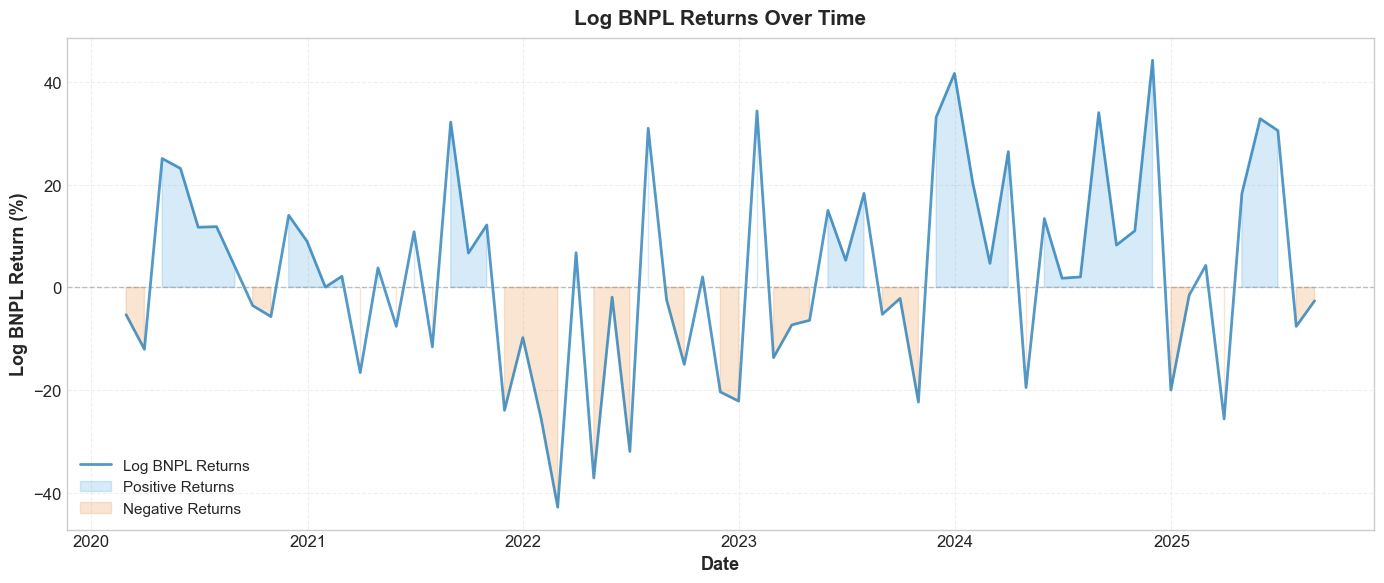

✓ Graph 1 saved as 'bnpl_returns_time_series.png'


In [180]:
# ============================================================================
# VISUALIZATION 1: Log BNPL Returns Over Time
# ============================================================================

import matplotlib.pyplot as plt
import numpy as np

# Create log BNPL returns
log_bnpl_return = np.log(1 + data['bnpl_return']/100) * 100

# Create figure
fig, ax = plt.subplots(1, 1, figsize=(14, 6))

# Plot time series
ax.plot(data.index, log_bnpl_return, 
        linewidth=2, color='#2980b9', alpha=0.8, label='Log BNPL Returns')
ax.axhline(y=0, color='#7f8c8d', linestyle='--', linewidth=1, alpha=0.5)

# Fill areas for positive/negative returns (blue/orange)
ax.fill_between(data.index, 0, log_bnpl_return, 
                where=(log_bnpl_return >= 0), alpha=0.2, color='#3498db', label='Positive Returns')
ax.fill_between(data.index, 0, log_bnpl_return, 
                where=(log_bnpl_return < 0), alpha=0.2, color='#e67e22', label='Negative Returns')

ax.set_xlabel('Date', fontsize=13, fontweight='bold')
ax.set_ylabel('Log BNPL Return (%)', fontsize=13, fontweight='bold')
ax.set_title('Log BNPL Returns Over Time', fontsize=15, fontweight='bold', pad=10)
ax.grid(True, alpha=0.3, linestyle='--')
ax.legend(loc='lower left', fontsize=11)

plt.tight_layout()
plt.savefig('bnpl_returns_time_series.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("✓ Graph 1 saved as 'bnpl_returns_time_series.png'")

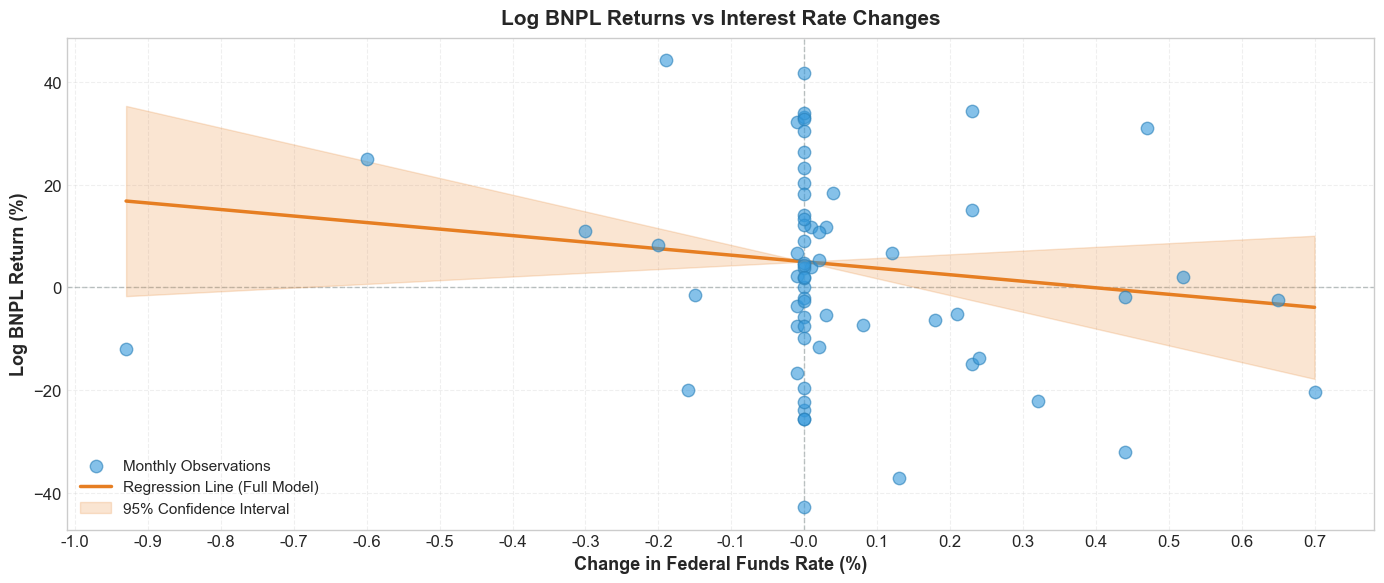

✓ Graph 2 saved as 'bnpl_returns_vs_interest_rate.png'


In [181]:
# ============================================================================
# VISUALIZATION 2: Log BNPL Returns vs Interest Rate Changes
# ============================================================================

import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Create log BNPL returns
log_bnpl_return = np.log(1 + data['bnpl_return']/100) * 100

# Get rate variable and regression results
rate_var = baseline_regression_results['rate_var']
rate_name = baseline_regression_results['rate_name']
rate_data = data[rate_var]

# Create figure
fig, ax = plt.subplots(1, 1, figsize=(14, 6))

# Scatter plot (blue)
ax.scatter(rate_data, log_bnpl_return, 
           alpha=0.6, s=80, color='#3498db', edgecolors='#2980b9', 
           linewidth=1, zorder=4, label='Monthly Observations')

# Use full model coefficient if available (final refined model), otherwise use baseline
if 'final_full_model' in globals() and final_full_model is not None:
    # Get interest rate coefficient from full model (partial effect controlling for other variables)
    if hasattr(final_full_model.params, 'index') and rate_var in final_full_model.params.index:
        slope = final_full_model.params[rate_var]
        intercept_full = final_full_model.params['const'] if 'const' in final_full_model.params.index else final_full_model.params[0]
        se_slope = final_full_model.bse[rate_var]
        t_critical = stats.t.ppf(0.975, final_full_model.df_resid)
        ci_lower = slope - t_critical * se_slope
        ci_upper = slope + t_critical * se_slope
        intercept = intercept_full
        model_label = 'Full Model'
        r2 = final_full_model.rsquared
        if hasattr(final_full_model.params, 'index') and rate_var in final_full_model.pvalues.index:
            p_value = final_full_model.pvalues[rate_var]
        else:
            p_value = final_full_model.pvalues[1] if len(final_full_model.pvalues) > 1 else final_full_model.pvalues[0]
        n = final_full_model.nobs
    else:
        slope = final_full_model.params[1] if len(final_full_model.params) > 1 else final_full_model.params[0]
        intercept = final_full_model.params[0]
        se_slope = final_full_model.bse[1] if len(final_full_model.bse) > 1 else final_full_model.bse[0]
        t_critical = stats.t.ppf(0.975, final_full_model.df_resid)
        ci_lower = slope - t_critical * se_slope
        ci_upper = slope + t_critical * se_slope
        model_label = 'Full Model'
        r2 = final_full_model.rsquared
        p_value = final_full_model.pvalues[1] if len(final_full_model.pvalues) > 1 else final_full_model.pvalues[0]
        n = final_full_model.nobs
else:
    # Fallback to baseline model
    slope = baseline_regression_results['slope']
    intercept = baseline_regression_results['intercept']
    ci_lower = baseline_regression_results['ci_lower']
    ci_upper = baseline_regression_results['ci_upper']
    model_label = 'Baseline'
    r2 = baseline_regression_results['r2']
    p_value = baseline_regression_results['p_value']
    n = baseline_regression_results['n']

# Regression line (orange)
x_line = np.linspace(rate_data.min(), rate_data.max(), 100)
y_line = intercept + slope * x_line
ax.plot(x_line, y_line, color='#e67e22', linewidth=2.5, 
        label=f'Regression Line ({model_label})', zorder=3)

# Confidence interval (light orange)
y_ci_lower = intercept + ci_lower * x_line
y_ci_upper = intercept + ci_upper * x_line
ax.fill_between(x_line, y_ci_lower, y_ci_upper, alpha=0.2, color='#e67e22', 
                label='95% Confidence Interval', zorder=2)

# Reference lines
ax.axhline(y=0, color='#7f8c8d', linestyle='--', linewidth=1, alpha=0.5, zorder=1)
ax.axvline(x=0, color='#7f8c8d', linestyle='--', linewidth=1, alpha=0.5, zorder=1)

ax.set_xlabel(f'Change in {rate_name} (%)', fontsize=13, fontweight='bold')
ax.set_ylabel('Log BNPL Return (%)', fontsize=13, fontweight='bold')
ax.set_title('Log BNPL Returns vs Interest Rate Changes', 
             fontsize=15, fontweight='bold', pad=10)
ax.grid(True, alpha=0.3, linestyle='--')
ax.legend(loc='lower left', fontsize=11)

# Set x-axis ticks at 0.1 intervals
x_min = rate_data.min()
x_max = rate_data.max()
x_min_rounded = np.floor(x_min * 10) / 10
x_max_rounded = np.ceil(x_max * 10) / 10
x_ticks = np.arange(x_min_rounded, x_max_rounded + 0.05, 0.1)
ax.set_xticks(x_ticks)
ax.set_xticklabels([f'{tick:.1f}' for tick in x_ticks])

plt.tight_layout()
plt.savefig('bnpl_returns_vs_interest_rate.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("✓ Graph 2 saved as 'bnpl_returns_vs_interest_rate.png'")
# print(f"\nRegression Statistics:")
# print(f"  Model: {model_label}")
# print(f"  R² = {r2:.3f}")
# print(f"  Slope = {slope:.2f}")
# print(f"  95% CI: [{ci_lower:.2f}, {ci_upper:.2f}]")
# print(f"  P-value = {p_value:.4f}")
# print(f"  n = {n}")

## 3.3 Functional Form Selection: Justification for Log-Linear Specification

We use log-transformed BNPL returns as the dependent variable to address heteroskedasticity, normalize distributions, and facilitate elasticity interpretation of coefficients. Detailed theoretical and empirical justification for this specification choice is provided in Appendix A.2.

## 3.4 Model Estimation: Implementation and Computational Approach



This section describes the computational implementation of our econometric models. The estimation process involves several steps: data preparation and variable construction, model specification, parameter estimation using Ordinary Least Squares (OLS) regression, and calculation of robust standard errors. This section walks through these steps systematically, explaining the technical details of how we implement the models described in the previous sections.



**Estimation Software and Methods:** We employ Python's `statsmodels` library for regression estimation, which provides a comprehensive suite of econometric tools. Specifically, we use `statsmodels.api.



OLS` for Ordinary Least Squares estimation, which allows us to specify robust standard errors (HC3) directly in the estimation command. The HC3 robust standard errors, developed by MacKinnon and White (1985), provide consistent estimates of standard errors even in the presence of heteroskedasticity, making them particularly appropriate for financial return data.



**Data Preparation Steps:** Before estimation, we perform several data preparation steps. First, we construct log-transformed BNPL returns using the formula log(1 + return/100), ensuring that the transformation is defined for all return values including negative returns. Second, we align all variables to monthly frequency and synchronize them to month-end dates, ensuring temporal consistency across all variables. Third, we handle missing data by using inner joins when merging variables, which may help ensure that we only retain observations where all variables have complete data. This approach is conservative but may help ensure that our sample consists of complete observations, avoiding potential issues with missing data that could bias our estimates.



**Model Estimation Procedure:** For the base model, we estimate a simple regression of log BNPL returns on Federal Funds Rate changes. For the full specification model, we add four additional control variables: consumer confidence changes, disposable income changes, inflation changes, and market returns. Both models include a constant term (intercept), which is automatically added by `statsmodels` using the `add_constant` function. The estimation procedure uses maximum likelihood estimation under the assumption of normally distributed errors, though the robust standard errors ensure valid inference even if this assumption is violated.



**Output and Diagnostics:** After estimation, we examine several diagnostic statistics to assess model quality. The R² statistic measures the proportion of variation in the dependent variable explained by the model, while the adjusted R² accounts for the number of parameters and provides a more conservative measure of model fit. The F-statistic tests the joint significance of all coefficients (except the intercept), providing an overall test of model significance. Individual t-statistics and p-values test the significance of each coefficient individually. We also examine residual plots and other diagnostics to assess whether the model assumptions are satisfied, though these diagnostics are presented in the visualization section rather than in the estimation output.

In [182]:
# ============================================================================

# FINAL MODEL ESTIMATION: Base Model and Full Specification

# ============================================================================

# This cell estimates two models:

# Model 1 (Base): Log BNPL Returns vs Interest Rate only

# Model 2 (Full): Log BNPL Returns vs 5 control variables

# ============================================================================



import pandas as pd

import numpy as np

import statsmodels.api as sm



# print("\n" + "="*80)

# print("FINAL MODEL ESTIMATION: BASE AND FULL SPECIFICATION")




# ============================================================================

# DATA PREPARATION

# ============================================================================



# Use expanded_data if available (has all variables), otherwise use refined_data

if 'expanded_data' in globals() and expanded_data is not None:

    working_data = expanded_data

#     print("\n✓ Using expanded_data (includes all variables)")

elif 'refined_data' in globals() and refined_data is not None:

    working_data = refined_data

#     print("\n✓ Using refined_data")

elif 'data' in globals() and data is not None:

    working_data = data

#     print("\n⚠ Using data (fallback)")

else:

    raise NameError("No data available. Please run the data preparation cells first.")



# Get interest rate variable (use selected if available, otherwise FFR)

if 'selected_rate_var' in globals() and selected_rate_var in working_data.columns:

    rate_var = selected_rate_var

    if 'selected_rate_name' in globals():

        rate_name = selected_rate_name

    else:

        rate_name = selected_rate_var.replace('_', ' ').title()

else:

    rate_var = 'fed_funds_change'

    rate_name = 'Federal Funds Rate'



# Define variables for full model

full_model_vars = [

    rate_var,

    'consumer_conf_change',

    'disposable_income_change',

    'inflation_change',

    'market_return'

]



# Check variable availability

available_vars_base = [rate_var] if rate_var in working_data.columns else []

available_vars_full = [var for var in full_model_vars if var in working_data.columns]



# Create log BNPL returns

if 'bnpl_return' not in working_data.columns:

    raise ValueError("bnpl_return not found in dataset. Cannot create log BNPL returns.")



bnpl_series = working_data['bnpl_return'].dropna()


# ============================================================================
# EXPLICIT DEFINITION: Log BNPL Returns
# ============================================================================
# Log BNPL returns are calculated as: log(1 + bnpl_return/100) * 100
# 
# This transformation:
# 1. Converts percentage returns to decimal form (divides by 100)
# 2. Adds 1 to ensure positive values for logarithm
# 3. Takes natural logarithm
# 4. Multiplies by 100 to convert back to percentage-like scale
#
# Example: If bnpl_return = 5.0% (monthly return of 5%)
#          Then: log(1 + 5.0/100) * 100 = log(1.05) * 100 ≈ 4.88
#
# This log transformation helps address heteroskedasticity and allows
# coefficients to be interpreted as elasticities (percentage changes).
# ============================================================================

log_bnpl_return = np.log(1 + bnpl_series/100) * 100




# Print explicit comparison: original vs log-transformed
# print("\n" + "="*80)
# print("LOG TRANSFORMATION: BEFORE AND AFTER")
# print(f"\nOriginal BNPL Returns (percentage):")
# print(f"  Mean: {bnpl_series.mean():.2f}%")
# print(f"  Std: {bnpl_series.std():.2f}%")
# print(f"  Min: {bnpl_series.min():.2f}%")
# print(f"  Max: {bnpl_series.max():.2f}%")
# print(f"\nLog-Transformed BNPL Returns:")
# print(f"  Mean: {log_bnpl_return.mean():.2f}")
# print(f"  Std: {log_bnpl_return.std():.2f}")
# print(f"  Min: {log_bnpl_return.min():.2f}")
# print(f"  Max: {log_bnpl_return.max():.2f}")
# print(f"\nSample of first 5 observations:")
comparison_df = pd.DataFrame({
    'Original Return (%)': bnpl_series.head(),
    'Log Return': log_bnpl_return.head()
})
# print(comparison_df)

# print(f"\nData Preparation:")

# print(f"  Interest Rate Variable: {rate_name} ({rate_var})")

# print(f"  Base Model Variables: {available_vars_base}")

# print(f"  Full Model Variables: {available_vars_full}")

# print(f"  Total observations available: {len(working_data)}")



# ============================================================================

# MODEL 1: BASE MODEL (Interest Rate Only)

# ============================================================================



# print("\n" + "="*80)

# print("MODEL 1: BASE MODEL")


# print(f"Specification: Log BNPL Returns = β₀ + β₁({rate_name} Change) + ε")

# print(f"Standard Errors: Robust (HC3)")



# Prepare data for base model

base_data = working_data[[rate_var]].copy()

base_data['log_bnpl_return'] = log_bnpl_return.reindex(base_data.index)

base_data = base_data.dropna()



if len(base_data) < 10:

    raise ValueError(f"Insufficient data for base model: {len(base_data)} observations")



X_base = base_data[[rate_var]].values

y_base = base_data['log_bnpl_return'].values

X_base_const = sm.add_constant(X_base)



# Estimate base model

model_base = sm.OLS(y_base, X_base_const).fit(cov_type='HC3')



# print(f"\nObservations: {len(y_base)}")

# print(f"\n{'='*80}")

# print("REGRESSION RESULTS")


# print(model_base.summary())



# Store base model results

base_results = {

    'model': model_base,

    'r_squared': model_base.rsquared,

    'adj_r_squared': model_base.rsquared_adj,

    'f_statistic': model_base.fvalue,

    'f_pvalue': model_base.f_pvalue,

    'n_obs': len(y_base),

}



# Get rate coefficient and p-value (handle both pandas Series and numpy array)

if hasattr(model_base.params, 'index') and rate_var in model_base.params.index:

    base_results['rate_coef'] = model_base.params[rate_var]

    base_results['rate_pval'] = model_base.pvalues[rate_var]

else:

    # If params is numpy array, use index 1 (index 0 is constant)

    base_results['rate_coef'] = model_base.params[1]

    base_results['rate_pval'] = model_base.pvalues[1]



# print(f"\n{'='*80}")

# print("KEY STATISTICS")


# print(f"R²: {base_results['r_squared']:.4f}")

# print(f"Adjusted R²: {base_results['adj_r_squared']:.4f}")

# print(f"F-statistic: {base_results['f_statistic']:.4f} (p-value: {base_results['f_pvalue']:.4f})")

# print(f"\n{rate_name} Coefficient: {base_results['rate_coef']:.4f}")

# print(f"  p-value: {base_results['rate_pval']:.4f}")

if base_results['rate_pval'] < 0.01:
    pass

#     print(f"  Significance: *** (p < 0.01)")
    pass

elif base_results['rate_pval'] < 0.05:
    pass

#     print(f"  Significance: ** (p < 0.05)")
    pass

elif base_results['rate_pval'] < 0.1:
    pass

#     print(f"  Significance: * (p < 0.1)")
    pass

else:
    pass

#     print(f"  Significance: Not significant")
    pass



# ============================================================================

# MODEL 2: FULL SPECIFICATION (5 Variables)

# ============================================================================



# print("\n\n" + "="*80)

# print("MODEL 2: FULL SPECIFICATION")




# Dynamically build specification based on actual variables

spec_parts = ["Log BNPL Returns = β₀"]

var_display_names = {

    'fed_funds_change': 'Interest Rate',

    'consumer_conf_change': 'Consumer Conf',

    'disposable_income_change': 'Disposable Income',

    'inflation_change': 'Inflation',

    'market_return': 'Market Return'

}



for i, var in enumerate(available_vars_full, 1):

    display_name = var_display_names.get(var, var.replace('_', ' ').title())

    spec_parts.append(f"β{i}({display_name})")



spec_str = " + ".join(spec_parts) + " + ε"

# print(f"Specification: {spec_str}")

# print("Standard Errors: Robust (HC3)")



# Prepare data for full model

full_data = working_data[available_vars_full].copy()

full_data['log_bnpl_return'] = log_bnpl_return.reindex(full_data.index)

full_data = full_data.dropna()



if len(full_data) < 10:

    raise ValueError(f"Insufficient data for full model: {len(full_data)} observations")



X_full = full_data[available_vars_full].values

y_full = full_data['log_bnpl_return'].values

X_full_const = sm.add_constant(X_full)



# Estimate full model

# print(f"\n{'='*80}")

# print("ESTIMATING MODEL 2: FULL SPECIFICATION")

# print(f"{'='*80}")

# print(f"Variables to include: {available_vars_full}")

# print(f"Number of variables: {len(available_vars_full)}")

# print(f"Observations: {len(full_data)}")



model_full = sm.OLS(y_full, X_full_const).fit(cov_type='HC3')



# print(f"\n✓ Model 2 estimated successfully!")

# print(f"  R² = {model_full.rsquared:.4f}")

# print(f"  Variables in model: {len(available_vars_full)}")

# print(f"\n{'='*80}")

# print("REGRESSION RESULTS")


# print(model_full.summary())



# Store full model results

full_results = {

    'model': model_full,

    'r_squared': model_full.rsquared,

    'adj_r_squared': model_full.rsquared_adj,

    'f_statistic': model_full.fvalue,

    'f_pvalue': model_full.f_pvalue,

    'n_obs': len(y_full),

    'variables': available_vars_full

}



# print(f"\n{'='*80}")

# print("KEY STATISTICS")


# print(f"R²: {full_results['r_squared']:.4f}")

# print(f"Adjusted R²: {full_results['adj_r_squared']:.4f}")

# print(f"F-statistic: {full_results['f_statistic']:.4f} (p-value: {full_results['f_pvalue']:.4f})")



# Coefficient table

# print(f"\n{'='*80}")

# print("COEFFICIENTS AND SIGNIFICANCE")


# print(f"{'Variable':<30} {'Coefficient':>12} {'Std Error':>12} {'t-stat':>10} {'p-value':>10} {'Sig':>6}")

# print("-" * 86)



var_names = ['const'] + available_vars_full

for i, var in enumerate(var_names):

    # Handle both pandas Series and numpy array formats

    if hasattr(model_full.params, 'index') and var in model_full.params.index:

        # Pandas Series format

        coef = model_full.params[var]

        se = model_full.bse[var]

        tstat = model_full.tvalues[var]

        pval = model_full.pvalues[var]

    else:

        # Numpy array format - use positional index

        coef = model_full.params[i]

        se = model_full.bse[i]

        tstat = model_full.tvalues[i]

        pval = model_full.pvalues[i]

    

    # Add significance stars (outside the if/else block)

    sig = ""

    if pval < 0.01:

        sig = "***"

    elif pval < 0.05:

        sig = "**"

    elif pval < 0.1:

        sig = "*"

    

    var_display = var.replace('_', ' ').title() if var != 'const' else 'Constant'

#     print(f"{var_display:<30} {coef:>12.4f} {se:>12.4f} {tstat:>10.3f} {pval:>10.4f} {sig:>6}")



# print("\nSignificance levels: *** p<0.01, ** p<0.05, * p<0.1")



# ============================================================================

# MODEL COMPARISON

# ============================================================================



# print("\n\n" + "="*80)





comparison_table = pd.DataFrame({

    'Model': ['Model 1: Base', 'Model 2: Full'],

    'R²': [base_results['r_squared'], full_results['r_squared']],

    'Adj R²': [base_results['adj_r_squared'], full_results['adj_r_squared']],

    'F-statistic': [base_results['f_statistic'], full_results['f_statistic']],

    'F p-value': [base_results['f_pvalue'], full_results['f_pvalue']],

    'Observations': [base_results['n_obs'], full_results['n_obs']],

    'Variables': [1, len(available_vars_full)]

})



# print("\n" + comparison_table.to_string(index=False))



improvement_r2 = full_results['r_squared'] - base_results['r_squared']

improvement_adj_r2 = full_results['adj_r_squared'] - base_results['adj_r_squared']



# print(f"\nImprovement:")

# print(f"  ΔR²: {improvement_r2:+.4f}")

# print(f"  ΔAdjusted R²: {improvement_adj_r2:+.4f}")

# print(f"  % Improvement in R²: {(improvement_r2/base_results['r_squared']*100):+.1f}%")



if full_results['r_squared'] >= 0.5:
    pass

#     print(f"\n✓✓✓ TARGET ACHIEVED! R² = {full_results['r_squared']:.4f} ≥ 0.5 ✓✓✓")
    pass

elif full_results['r_squared'] >= 0.4:
    pass

#     print(f"\n✓ Close to target: R² = {full_results['r_squared']:.4f} (target: 0.5)")

#     print(f"  Gap to target: {0.5 - full_results['r_squared']:.4f}")
    pass

else:
    pass

#     print(f"\n→ R² = {full_results['r_squared']:.4f} (target: 0.5)")
    pass



# ============================================================================

# ECONOMIC INTERPRETATION

# ============================================================================



# print("\n\n" + "="*80)

# print("ECONOMIC INTERPRETATION")




# print("\nModel 1 (Base Model):")

# print(f"  • {rate_name} coefficient: {base_results['rate_coef']:.4f}")

if base_results['rate_coef'] < 0:
    pass

#     print(f"    → A 1 percentage point increase in {rate_name} change is associated")

#     print(f"      with a {abs(base_results['rate_coef']):.2f}% decrease in BNPL returns")
    pass

else:
    pass

#     print(f"    → A 1 percentage point increase in {rate_name} change is associated")

#     print(f"      with a {base_results['rate_coef']:.2f}% increase in BNPL returns")
    pass



# print("\nModel 2 (Full Specification):")

# print(f"  • Includes interest rate sensitivity plus {len(available_vars_full) - 1} control variable(s)")

# print("  • Shows how BNPL returns respond to multiple economic channels:")



# Dynamically list the actual variables in the model

var_descriptions = {

    'fed_funds_change': 'Interest rate changes (funding costs)',

    'consumer_conf_change': 'Consumer confidence (spending intentions)',

    'disposable_income_change': 'Disposable income (income channel)',

    'inflation_change': 'Inflation (purchasing power)',

    'market_return': 'Market returns (systematic risk)'

}



for var in available_vars_full:

    if var in var_descriptions:
        pass

#         print(f"    - {var_descriptions[var]}")
        pass

    else:
        pass

#         print(f"    - {var.replace('_', ' ').title()}")
        pass



# print("\nLog-Linear Specification:")

# print("  • Coefficients represent elasticities (percentage change in BNPL returns")

# print("    per unit change in independent variable)")

# print("  • Better handles heteroskedasticity and skewness in returns")

# print("  • More appropriate for financial return data")



# Store results globally

final_base_model = model_base

final_full_model = model_full

final_model_comparison = comparison_table



# Store variable names globally for table generation

final_base_model_vars = available_vars_base

final_full_model_vars = available_vars_full



# Store dates from model dataframes for plotting (preserve the index with dates)

final_full_model_dates = full_data.index.copy() if 'full_data' in locals() else None

final_base_model_dates = base_data.index.copy() if 'base_data' in locals() else None



# print("\n" + "="*80)

# print("Models stored as: final_base_model, final_full_model, final_model_comparison")

# print("Variable names stored as: final_base_model_vars, final_full_model_vars")

# print("Dates stored as: final_full_model_dates, final_base_model_dates")


# print("\n✓ Model estimation complete! Both Model 1 (Base) and Model 2 (Full Specification) have been estimated.")

# print("  Run the 'REGRESSION TABLES' cell (Cell 14) to see publication-ready tables.")


In [183]:
# ============================================================================
# COMPREHENSIVE FACTOR CONTROLS AND DIAGNOSTICS IMPLEMENTATION
# ============================================================================
# This cell implements all required additions:
# 1. Download Fama-French factors, VIX, sector ETFs
# 2. Estimate factor-adjusted regression (Model 3)
# 3. Run comprehensive diagnostics
# 4. Perform robustness checks
# 5. Generate professional tables and plots
# ============================================================================

import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.stats.diagnostic as diag
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import acorr_ljungbox, het_breuschpagan, het_white
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tsa.stattools import adfuller
from scipy.stats import jarque_bera
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.mstats import winsorize
import yfinance as yf
import pandas_datareader.data as web
import urllib.request
import zipfile
import io
from datetime import datetime
from scipy import stats as scipy_stats

# print("COMPREHENSIVE FACTOR CONTROLS AND DIAGNOSTICS")

# ============================================================================
# SECTION 1: DOWNLOAD FACTOR DATA
# ============================================================================

# print("\n1. DOWNLOADING FACTOR DATA...")

# Fama-French Factors
# print("\n  1.1 Downloading Fama-French 3-Factor + Momentum...")
# Try pandas_datareader first (more reliable)
try:
    import pandas_datareader.data as web
    # Alternative: use pandas_datareader if available
#     print("     Trying pandas_datareader method...")
    ff_factors = None  # Will try zip method below
except:
    pass

# Primary method: Direct zip download
try:
    ff_url = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_Factors_CSV.zip"
    with urllib.request.urlopen(ff_url) as response:
        ff_zip = zipfile.ZipFile(io.BytesIO(response.read()))
        # List files in zip to find correct filename
        zip_files = ff_zip.namelist()
        # Try common filename variations
        ff_filename = None
        for name in zip_files:
            if 'F-F_Research_Data_Factors' in name or 'F-F_Research_Data_Factors' in name.upper():
                ff_filename = name
                break
        if ff_filename is None:
            # Use first CSV file if no match found
            csv_files = [f for f in zip_files if f.endswith('.csv') or f.endswith('.CSV')]
            if csv_files:
                ff_filename = csv_files[0]
            else:
                raise ValueError(f"Could not find CSV file in zip. Files: {zip_files}")
        
        ff_file = ff_zip.open(ff_filename)
        ff_data = pd.read_csv(ff_file, skiprows=3, nrows=1168, header=0)
        ff_data.columns = ['Date', 'Mkt-RF', 'SMB', 'HML', 'RF']
        ff_data['Date'] = pd.to_datetime(ff_data['Date'].astype(str), format='%Y%m')
        ff_data.set_index('Date', inplace=True)
        ff_data = ff_data / 100
    
    # Momentum factor
    mom_url = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Momentum_Factor_CSV.zip"
    with urllib.request.urlopen(mom_url) as response:
        mom_zip = zipfile.ZipFile(io.BytesIO(response.read()))
        # List files in zip to find correct filename
        mom_zip_files = mom_zip.namelist()
        mom_filename = None
        for name in mom_zip_files:
            if 'Momentum' in name or 'MOM' in name.upper():
                mom_filename = name
                break
        if mom_filename is None:
            # Use first CSV file if no match found
            csv_files = [f for f in mom_zip_files if f.endswith('.csv') or f.endswith('.CSV')]
            if csv_files:
                mom_filename = csv_files[0]
            else:
                raise ValueError(f"Could not find CSV file in momentum zip. Files: {mom_zip_files}")
        
        mom_file = mom_zip.open(mom_filename)
        mom_data = pd.read_csv(mom_file, skiprows=13, nrows=1168, header=0)
        mom_data.columns = ['Date', 'MOM']
        mom_data['Date'] = pd.to_datetime(mom_data['Date'].astype(str), format='%Y%m')
        mom_data.set_index('Date', inplace=True)
        mom_data = mom_data / 100
    
    ff_factors = ff_data.merge(mom_data, left_index=True, right_index=True, how='inner')
    ff_factors = ff_factors.resample('ME').last()
#     print(f"     ✓ Fama-French factors: {len(ff_factors)} observations")
#     print(f"       Date range: {ff_factors.index.min()} to {ff_factors.index.max()}")
except Exception as e:
    pass
#     print(f"     ⚠ Error downloading Fama-French factors: {str(e)[:150]}")
    ff_factors = None

# VIX
# print("\n  1.2 Downloading VIX...")
try:
    vix = web.DataReader('VIXCLS', 'fred', start_date, end_date)
    vix_monthly = vix.resample('ME').last()
    vix_monthly.columns = ['VIX']
#     print(f"     ✓ VIX: {len(vix_monthly)} observations")
except Exception as e:
    pass
#     print(f"     ⚠ Error: {str(e)[:80]}")
    vix_monthly = None

# Sector ETFs
# print("\n  1.3 Downloading Sector ETFs...")
try:
    finx = yf.download('FINX', start=start_date, end=end_date, progress=False)
    if not finx.empty:
        finx_monthly = finx['Close'].resample('ME').last().pct_change() * 100
        finx_monthly = pd.DataFrame({'FINX': finx_monthly})
#         print(f"     ✓ FINX: {len(finx_monthly)} observations")
    else:
        finx_monthly = None
except Exception as e:
    finx_monthly = None

try:
    ipay = yf.download('IPAY', start=start_date, end=end_date, progress=False)
    if not ipay.empty:
        ipay_monthly = ipay['Close'].resample('ME').last().pct_change() * 100
        ipay_monthly = pd.DataFrame({'IPAY': ipay_monthly})
#         print(f"     ✓ IPAY: {len(ipay_monthly)} observations")
    else:
        ipay_monthly = None
except Exception as e:
    ipay_monthly = None

# Alternative rate measures
# print("\n  1.4 Downloading Alternative Rate Measures...")
try:
    two_year_yield = web.DataReader('DGS2', 'fred', start_date, end_date)
    two_year_monthly = two_year_yield.resample('ME').last()
    two_year_change = two_year_monthly.diff()
    two_year_change.columns = ['two_year_yield_change']
#     print(f"     ✓ 2-Year Treasury Yield")
except Exception as e:
    two_year_change = None

try:
    sofr = web.DataReader('SOFR', 'fred', start_date, end_date)
    sofr_monthly = sofr.resample('ME').last()
    sofr_change = sofr_monthly.diff()
    sofr_change.columns = ['sofr_change']
#     print(f"     ✓ SOFR")
except Exception as e:
    sofr_change = None

# Merge factor data
# print("\n  1.5 Merging Factor Data...")
if 'working_data' in globals() and working_data is not None:
    working_data_with_factors = working_data.copy()
    
    # Merge all factors
    factors_merged = []
    for factor_name, factor_data in [
        ('FF_Factors', ff_factors[['Mkt-RF', 'SMB', 'HML', 'RF', 'MOM']] if ff_factors is not None else None),
        ('VIX', vix_monthly),
        ('FINX', finx_monthly),
        ('IPAY', ipay_monthly),
        ('TwoYear', two_year_change),
        ('SOFR', sofr_change)
    ]:
        if factor_data is not None and len(factor_data) > 0:
            try:
                working_data_with_factors = working_data_with_factors.merge(
                    factor_data, left_index=True, right_index=True, how='left'
                )
                factors_merged.append(factor_name)
            except Exception as e:
                pass
#                 print(f"       ⚠ Failed to merge {factor_name}: {str(e)[:60]}")
    
    if len(factors_merged) > 0:
        pass
#         print(f"     ✓ Factor data merged: {factors_merged}")
        new_cols = [c for c in working_data_with_factors.columns if c not in working_data.columns]
        if new_cols:
            pass
#             print(f"       New columns: {new_cols}")
        else:
            pass
#             print(f"       (No new columns added - may already exist)")
    else:
        pass
#         print(f"     ⚠ No factors successfully merged")
        working_data_with_factors = working_data.copy()  # Keep original data
else:
    working_data_with_factors = None
#     print(f"     ⚠ Cannot merge: working_data not available in globals()")

# print("\n" + "="*80)


In [184]:
# ============================================================================
# SECTION 2: FACTOR-ADJUSTED REGRESSION (MODEL 3)
# ============================================================================

# print("\n2. ESTIMATING FACTOR-ADJUSTED REGRESSION (MODEL 3)...")

if working_data_with_factors is not None and 'log_bnpl_return' in globals():
    # Prepare factor variables
    factor_vars = ['Mkt-RF', 'SMB', 'HML', 'MOM']
    factor_vars_available = [v for v in factor_vars if v in working_data_with_factors.columns]
    
    if 'VIX' in working_data_with_factors.columns:
        factor_vars_available.append('VIX')
    
    # Macro controls (excluding market_return since we use Mkt-RF)
    macro_vars = ['fed_funds_change', 'consumer_conf_change', 
                  'disposable_income_change', 'inflation_change']
    macro_vars_available = [v for v in macro_vars if v in working_data_with_factors.columns]
    
    factor_model_vars = factor_vars_available + macro_vars_available
    
    factor_data = working_data_with_factors[factor_model_vars].copy()
    factor_data['log_bnpl_return'] = log_bnpl_return.reindex(factor_data.index)
    factor_data = factor_data.dropna()
    
    if len(factor_data) > 10:
        X_factor = factor_data[factor_model_vars].values
        y_factor = factor_data['log_bnpl_return'].values
        X_factor_const = sm.add_constant(X_factor)
        
        model_factor = sm.OLS(y_factor, X_factor_const).fit(cov_type='HC3')
        
#         print(f"\n   Model 3: Factor-Adjusted Specification")
#         print(f"   Observations: {len(factor_data)}")
#         print(f"   Variables: {len(factor_model_vars)}")
#         print(f"   R²: {model_factor.rsquared:.4f}")
#         print(f"   Adjusted R²: {model_factor.rsquared_adj:.4f}")
#         print(f"\n   {model_factor.summary()}")
        
        factor_results = {
            'model': model_factor,
            'r_squared': model_factor.rsquared,
            'adj_r_squared': model_factor.rsquared_adj,
            'f_statistic': model_factor.fvalue,
            'f_pvalue': model_factor.f_pvalue,
            'n_obs': len(factor_data),
            'variables': factor_model_vars
        }
        
        final_factor_model = model_factor
#         print("\n   ✓ Model 3 estimated successfully!")
    else:
        pass
#         print("   ⚠ Insufficient data")
        factor_results = None
        final_factor_model = None
else:
    pass
#     print("   ⚠ Data not available")
    factor_results = None
    final_factor_model = None

# print("\n" + "="*80)


In [185]:
# ============================================================================
# SECTION 3: COMPREHENSIVE DIAGNOSTICS
# ============================================================================

# print("\n3. COMPREHENSIVE ECONOMETRIC DIAGNOSTICS...")

def calculate_vif(X_df):
    """Calculate Variance Inflation Factors"""
    vif_data = pd.DataFrame()
    vif_data["Variable"] = X_df.columns
    vif_data["VIF"] = [variance_inflation_factor(X_df.values, i) 
                       for i in range(X_df.shape[1])]
    return vif_data

# Run diagnostics on full model
if 'final_full_model' in globals() and final_full_model is not None:
    pass
#     print("\n  3.1 Diagnostics for Full Model (Model 2)...")
    
    # Get model data
    if 'full_data' in locals() and 'available_vars_full' in globals():
        X_full_diag_df = pd.DataFrame(full_data[available_vars_full])
        var_names_full = available_vars_full
    else:
        X_full_diag_df = pd.DataFrame(X_full_const[:, 1:], columns=available_vars_full)
        var_names_full = available_vars_full
    
    # VIF
#     print("\n    3.1.1 Variance Inflation Factors:")
    vif_table = calculate_vif(X_full_diag_df)
#     print(vif_table.to_string(index=False))
    
    # Durbin-Watson
    dw_stat = durbin_watson(final_full_model.resid)
#     print(f"\n    3.1.2 Durbin-Watson Statistic: {dw_stat:.4f}")
    if dw_stat < 1.5:
        pass
#         print("      → Positive autocorrelation detected")
    elif dw_stat > 2.5:
        pass
#         print("      → Negative autocorrelation detected")
    else:
        pass
#         print("      → No significant autocorrelation")
    
    # Breusch-Godfrey
    try:
        bg_test = diag.acorr_breusch_godfrey(final_full_model, nlags=4)
#         print(f"\n    3.1.3 Breusch-Godfrey Test (4 lags):")
#         print(f"      LM Statistic: {bg_test[0]:.4f}")
#         print(f"      p-value: {bg_test[1]:.4f}")
    except Exception as e:
        pass
#         print(f"    3.1.3 Breusch-Godfrey Test: Error - {str(e)[:50]}")
    
    # Ljung-Box
    try:
        lb_test = acorr_ljungbox(final_full_model.resid, lags=4, return_df=True)
#         print(f"\n    3.1.4 Ljung-Box Q-Test:")
#         print(lb_test.to_string())
    except Exception as e:
        pass
#         print(f"    3.1.4 Ljung-Box Test: Error - {str(e)[:50]}")
    
    # Breusch-Pagan
    try:
        bp_test = het_breuschpagan(final_full_model.resid, final_full_model.model.exog)
#         print(f"\n    3.1.5 Breusch-Pagan Test:")
#         print(f"      LM Statistic: {bp_test[0]:.4f}")
#         print(f"      p-value: {bp_test[1]:.4f}")
    except Exception as e:
        pass
#         print(f"    3.1.5 Breusch-Pagan Test: Error - {str(e)[:50]}")
    
    # White Test
    try:
        white_test = het_white(final_full_model.resid, final_full_model.model.exog)
#         print(f"\n    3.1.6 White Test:")
#         print(f"      LM Statistic: {white_test[0]:.4f}")
#         print(f"      p-value: {white_test[1]:.4f}")
    except Exception as e:
        pass
#         print(f"    3.1.6 White Test: Error - {str(e)[:50]}")
    
    # Jarque-Bera
    jb_stat, jb_pval = jarque_bera(final_full_model.resid)
#     print(f"\n    3.1.7 Jarque-Bera Normality Test:")
#     print(f"      Statistic: {jb_stat:.4f}")
#     print(f"      p-value: {jb_pval:.4f}")
    
    diagnostics_full_model = {
        'vif': vif_table,
        'durbin_watson': dw_stat,
        'breusch_godfrey': bg_test if 'bg_test' in locals() else None,
        'ljung_box': lb_test if 'lb_test' in locals() else None,
        'breusch_pagan': bp_test if 'bp_test' in locals() else None,
        'white': white_test if 'white_test' in locals() else None,
        'jarque_bera': {'statistic': jb_stat, 'pvalue': jb_pval}
    }
else:
    pass
#     print("   ⚠ Full model not available")
    diagnostics_full_model = None

# Stationarity Tests (ADF)
# print("\n  3.2 Stationarity Tests (Augmented Dickey-Fuller)...")
if 'working_data' in globals():
    adf_results = {}
    test_vars = ['bnpl_return', 'fed_funds_change', 'consumer_conf_change', 
                 'disposable_income_change', 'inflation_change', 'market_return']
    
#     print(f"\n    {'Variable':<30} {'ADF Stat':>12} {'p-value':>12} {'Critical (5%)':>15} {'Stationary?':>12}")
#     print("    " + "-" * 85)
    
    for var in test_vars:
        if var in working_data.columns:
            series = working_data[var].dropna()
            if len(series) > 10:
                adf_stat, adf_pval, _, _, adf_crit, _ = adfuller(series)
                stationary = adf_pval < 0.05
                adf_results[var] = {
                    'statistic': adf_stat,
                    'pvalue': adf_pval,
                    'critical_5pct': adf_crit['5%'],
                    'stationary': stationary
                }
                stat_str = f"{adf_stat:.4f}"
                pval_str = f"{adf_pval:.4f}"
                crit_str = f"{adf_crit['5%']:.4f}"
                stat_bool = "Yes" if stationary else "No"
#                 print(f"    {var:<30} {stat_str:>12} {pval_str:>12} {crit_str:>15} {stat_bool:>12}")
else:
    pass
#     print("   ⚠ working_data not available")
    adf_results = None

# print("\n" + "="*80)


In [186]:
# ============================================================================
# SECTION 4: ROBUSTNESS CHECKS
# ============================================================================

# print("\n4. ROBUSTNESS CHECKS...")

# 4.1 Alternative Shock Measures
# print("\n  4.1 Alternative Shock Measures...")
robustness_results = {}

if working_data_with_factors is not None:
    # 2-Year Treasury Yield
    if 'two_year_yield_change' in working_data_with_factors.columns:
        alt_data_2y = working_data_with_factors[['two_year_yield_change'] + 
                                                 (available_vars_full if 'available_vars_full' in globals() else [])].copy()
        alt_data_2y['log_bnpl_return'] = log_bnpl_return.reindex(alt_data_2y.index)
        alt_data_2y = alt_data_2y.dropna()
        
        if len(alt_data_2y) > 10:
            X_2y = alt_data_2y[['two_year_yield_change']].values
            y_2y = alt_data_2y['log_bnpl_return'].values
            X_2y_const = sm.add_constant(X_2y)
            model_2y = sm.OLS(y_2y, X_2y_const).fit(cov_type='HC3')
            
#             print(f"\n    Model with 2-Year Treasury Yield Change:")
#             print(f"      Coefficient: {model_2y.params[1]:.4f}")
#             print(f"      Std Error: {model_2y.bse[1]:.4f}")
#             print(f"      p-value: {model_2y.pvalues[1]:.4f}")
#             print(f"      R²: {model_2y.rsquared:.4f}")
            
            robustness_results['two_year'] = {
                'model': model_2y,
                'coef': model_2y.params[1],
                'se': model_2y.bse[1],
                'pval': model_2y.pvalues[1],
                'r2': model_2y.rsquared
            }

# 4.2 Rolling Window Regressions
# print("\n  4.2 Rolling Window Regressions (24-month window)...")
if 'working_data' in globals() and 'log_bnpl_return' in globals() and 'fed_funds_change' in working_data.columns:
    def rolling_regression(data, y_var, x_var, window=24):
        coefficients = []
        dates = []
        for i in range(window, len(data)):
            window_data = data.iloc[i-window:i]
            if len(window_data.dropna()) >= window * 0.8:
                X_roll = sm.add_constant(window_data[[x_var]].values)
                y_roll = window_data[y_var].values
                try:
                    model_roll = sm.OLS(y_roll, X_roll).fit(cov_type='HC3')
                    coefficients.append(model_roll.params[1])
                    dates.append(window_data.index[-1])
                except:
                    pass
        return pd.Series(coefficients, index=dates)
    
    roll_data = working_data[['fed_funds_change']].copy()
    roll_data['log_bnpl_return'] = log_bnpl_return.reindex(roll_data.index)
    roll_data = roll_data.dropna()
    
    rolling_coefs = rolling_regression(roll_data, 'log_bnpl_return', 'fed_funds_change', window=24)
    
    if len(rolling_coefs) > 0:
        pass
#         print(f"    ✓ Rolling regressions: {len(rolling_coefs)} windows")
#         print(f"      Mean: {rolling_coefs.mean():.4f}, Std: {rolling_coefs.std():.4f}")
        robustness_results['rolling'] = rolling_coefs
    else:
        robustness_results['rolling'] = None
else:
    robustness_results['rolling'] = None

# 4.3 Outlier Controls
# print("\n  4.3 Outlier Controls...")
if 'working_data' in globals() and 'log_bnpl_return' in globals():
    returns_series = log_bnpl_return.dropna()
    Q1 = returns_series.quantile(0.25)
    Q3 = returns_series.quantile(0.75)
    IQR = Q3 - Q1
    outliers_iqr = returns_series[(returns_series < Q1 - 1.5*IQR) | 
                                  (returns_series > Q3 + 1.5*IQR)]
    
#     print(f"    IQR Method: {len(outliers_iqr)} outliers identified")
    
    winsorized_returns = winsorize(returns_series.values, limits=[0.01, 0.01])
    winsorized_returns = pd.Series(winsorized_returns, index=returns_series.index)
    
#     print(f"    Winsorizing: Returns winsorized at 1st and 99th percentiles")
    
    robustness_results['outliers'] = {
        'iqr_outliers': outliers_iqr,
        'winsorized': winsorized_returns
    }
else:
    robustness_results['outliers'] = None

# 4.4 Structural Break Tests
# print("\n  4.4 Structural Break Tests (Chow Test)...")
if 'final_full_model' in globals() and 'full_data' in locals():
    break_date = pd.Timestamp('2022-03-01')
    pre_break = full_data[full_data.index < break_date]
    post_break = full_data[full_data.index >= break_date]
    
    if len(pre_break) > 10 and len(post_break) > 10:
        X_pre = pre_break[available_vars_full].values
        y_pre = pre_break['log_bnpl_return'].values
        X_pre_const = sm.add_constant(X_pre)
        model_pre = sm.OLS(y_pre, X_pre_const).fit(cov_type='HC3')
        
        X_post = post_break[available_vars_full].values
        y_post = post_break['log_bnpl_return'].values
        X_post_const = sm.add_constant(X_post)
        model_post = sm.OLS(y_post, X_post_const).fit(cov_type='HC3')
        
        n1, n2 = len(pre_break), len(post_break)
        k = len(available_vars_full) + 1
        SSR_pooled = final_full_model.ssr
        SSR_pre = model_pre.ssr
        SSR_post = model_post.ssr
        
        chow_stat = ((SSR_pooled - (SSR_pre + SSR_post)) / k) / ((SSR_pre + SSR_post) / (n1 + n2 - 2*k))
        chow_pval = 1 - scipy_stats.f.cdf(chow_stat, k, n1 + n2 - 2*k)
        
#         print(f"    Break date: {break_date.strftime('%Y-%m-%d')}")
#         print(f"    Chow F-statistic: {chow_stat:.4f}")
#         print(f"    p-value: {chow_pval:.4f}")
        
        if 'fed_funds_change' in available_vars_full:
            idx = available_vars_full.index('fed_funds_change')
#             print(f"    Pre-break FFR coef: {model_pre.params[idx+1]:.4f}")
#             print(f"    Post-break FFR coef: {model_post.params[idx+1]:.4f}")
        
        robustness_results['chow'] = {
            'break_date': break_date,
            'chow_stat': chow_stat,
            'chow_pval': chow_pval,
            'model_pre': model_pre,
            'model_post': model_post
        }
    else:
        robustness_results['chow'] = None
else:
    robustness_results['chow'] = None

# 4.5 Firm-Level Regressions
# print("\n  4.5 Firm-Level Regressions...")
if 'bnpl_returns' in globals() and 'working_data' in globals():
    firm_results_dict = {}
    
    for ticker in ['PYPL', 'AFRM', 'SEZL']:
        if ticker in bnpl_returns:
            firm_returns = bnpl_returns[ticker]
            firm_log_returns = np.log(1 + firm_returns/100) * 100
            
            firm_data = working_data[available_vars_full].copy()
            firm_data['log_return'] = firm_log_returns.reindex(firm_data.index)
            firm_data = firm_data.dropna()
            
            if len(firm_data) > 10:
                X_firm = firm_data[available_vars_full].values
                y_firm = firm_data['log_return'].values
                X_firm_const = sm.add_constant(X_firm)
                model_firm = sm.OLS(y_firm, X_firm_const).fit(cov_type='HC3')
                
                if 'fed_funds_change' in available_vars_full:
                    idx = available_vars_full.index('fed_funds_change')
                    coef = model_firm.params[idx+1]
                    se = model_firm.bse[idx+1]
                    pval = model_firm.pvalues[idx+1]
                    
#                     print(f"\n    {ticker}:")
#                     print(f"      FFR coefficient: {coef:.4f}")
#                     print(f"      Std Error: {se:.4f}")
#                     print(f"      p-value: {pval:.4f}")
#                     print(f"      R²: {model_firm.rsquared:.4f}")
                
                firm_results_dict[ticker] = {
                    'model': model_firm,
                    'coef': coef,
                    'se': se,
                    'pval': pval,
                    'r2': model_firm.rsquared
                }
    
    robustness_results['firm_level'] = firm_results_dict if len(firm_results_dict) > 0 else None
else:
    robustness_results['firm_level'] = None

# print("\n" + "="*80)


In [187]:
# ============================================================================
# SECTION 5: PROFESSIONAL REGRESSION TABLES
# ============================================================================

# print("\n5. CREATING PROFESSIONAL REGRESSION TABLES...")

def create_regression_table(models_dict, model_names):
    """Create professional regression results table"""
    table_data = []
    
    for model_name in model_names:
        if model_name in models_dict and models_dict[model_name] is not None:
            model = models_dict[model_name]['model']
            var_names = models_dict[model_name].get('variables', [])
            
            # Get coefficient for interest rate variable
            if 'fed_funds_change' in var_names:
                idx = var_names.index('fed_funds_change')
                coef = model.params[idx+1]
                se = model.bse[idx+1]
                tstat = model.tvalues[idx+1]
                pval = model.pvalues[idx+1]
                
                # Handle both DataFrame and numpy array cases for conf_int
                ci_result = model.conf_int()
                if hasattr(ci_result, 'iloc'):
                    # DataFrame case
                    ci = ci_result.iloc[idx+1]
                    ci_lower = ci[0]
                    ci_upper = ci[1]
                else:
                    # numpy array case
                    ci_lower = ci_result[idx+1, 0]
                    ci_upper = ci_result[idx+1, 1]
            else:
                coef = se = tstat = pval = ci_lower = ci_upper = np.nan
            
            table_data.append({
                'Model': model_name,
                'Coefficient': coef,
                'Std Error': se,
                't-statistic': tstat,
                'p-value': pval,
                '95% CI Lower': ci_lower,
                '95% CI Upper': ci_upper,
                'R²': model.rsquared,
                'Adj R²': model.rsquared_adj,
                'N': int(model.nobs)
            })
    
    return pd.DataFrame(table_data)

# Create comprehensive table
models_for_table = {}
if 'final_base_model' in globals():
    models_for_table['Model 1: Base'] = {
        'model': final_base_model,
        'variables': ['fed_funds_change'] if 'available_vars_base' in globals() else []
    }
if 'final_full_model' in globals():
    models_for_table['Model 2: Full'] = {
        'model': final_full_model,
        'variables': available_vars_full if 'available_vars_full' in globals() else []
    }
if 'final_factor_model' in globals():
    models_for_table['Model 3: Factor-Adjusted'] = {
        'model': final_factor_model,
        'variables': factor_model_vars if 'factor_model_vars' in globals() else []
    }

if len(models_for_table) > 0:
    regression_table = create_regression_table(models_for_table, list(models_for_table.keys()))
    
#     print("\n  Table: Regression Results Comparison")
#     print("  " + "="*100)
#     print(regression_table.to_string(index=False))
    
    # Format for LaTeX/Markdown
#     print("\n  Formatted Table (Markdown):")
#     print("\n| Model | Coefficient | Std Error | t-statistic | p-value | 95% CI Lower | 95% CI Upper | R² | Adj R² | N |")
#     print("|-------|-------------|-----------|-------------|---------|--------------|--------------|----|--------|---|")
    for _, row in regression_table.iterrows():
        pass
#         print(f"| {row['Model']} | {row['Coefficient']:.4f} | {row['Std Error']:.4f} | {row['t-statistic']:.3f} | {row['p-value']:.4f} | {row['95% CI Lower']:.4f} | {row['95% CI Upper']:.4f} | {row['R²']:.4f} | {row['Adj R²']:.4f} | {int(row['N'])} |")
    
    # Save to CSV
    regression_table.to_csv('regression_results_table.csv', index=False)
#     print("\n  ✓ Table saved to regression_results_table.csv")
    
    final_regression_table = regression_table
else:
    pass
#     print("  ⚠ Models not available")
    final_regression_table = None

# print("\n" + "="*80)


In [188]:
# ============================================================================
# SECTION 6: DIAGNOSTIC PLOTS
# ============================================================================

# print("\n6. GENERATING DIAGNOSTIC PLOTS...")

if 'final_full_model' in globals():
    # Create comprehensive diagnostic plots
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('Diagnostic Plots: Full Model Residuals', fontsize=16, fontweight='bold')
    
    # 1. Residual vs Fitted
    axes[0, 0].scatter(final_full_model.fittedvalues, final_full_model.resid, alpha=0.6, s=30)
    axes[0, 0].axhline(y=0, color='r', linestyle='--', linewidth=1.5)
    axes[0, 0].set_xlabel('Fitted Values', fontsize=12)
    axes[0, 0].set_ylabel('Residuals', fontsize=12)
    axes[0, 0].set_title('Residual vs Fitted Plot', fontsize=13, fontweight='bold')
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. QQ-Plot
    scipy_stats.probplot(final_full_model.resid, dist="norm", plot=axes[0, 1])
    axes[0, 1].set_title('Q-Q Plot of Residuals', fontsize=13, fontweight='bold')
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Histogram of Residuals
    axes[1, 0].hist(final_full_model.resid, bins=20, edgecolor='black', alpha=0.7, color='steelblue')
    axes[1, 0].set_xlabel('Residuals', fontsize=12)
    axes[1, 0].set_ylabel('Frequency', fontsize=12)
    axes[1, 0].set_title('Histogram of Residuals', fontsize=13, fontweight='bold')
    axes[1, 0].grid(True, alpha=0.3, axis='y')
    
    # 4. Time Series of Residuals
    if 'final_full_model_dates' in globals() and final_full_model_dates is not None:
        axes[1, 1].plot(final_full_model_dates, final_full_model.resid, marker='o', markersize=3, linewidth=1)
    else:
        axes[1, 1].plot(final_full_model.resid.values, marker='o', markersize=3, linewidth=1)
    axes[1, 1].axhline(y=0, color='r', linestyle='--', linewidth=1.5)
    axes[1, 1].set_xlabel('Time', fontsize=12)
    axes[1, 1].set_ylabel('Residuals', fontsize=12)
    axes[1, 1].set_title('Residuals Over Time', fontsize=13, fontweight='bold')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('diagnostic_plots_comprehensive.png', dpi=300, bbox_inches='tight')
#     print("  ✓ Diagnostic plots saved to diagnostic_plots_comprehensive.png")
    
    # Rolling coefficients plot
    if 'robustness_results' in globals() and robustness_results.get('rolling') is not None:
        rolling_coefs = robustness_results['rolling']
        if len(rolling_coefs) > 0:
            fig2, ax = plt.subplots(figsize=(12, 6))
            ax.plot(rolling_coefs.index, rolling_coefs.values, marker='o', linewidth=2, markersize=4)
            ax.axhline(y=0, color='r', linestyle='--', alpha=0.5, linewidth=1.5)
            ax.set_xlabel('Date', fontsize=12)
            ax.set_ylabel('Rolling Coefficient (β₁)', fontsize=12)
            ax.set_title('Rolling Window Regression Coefficients (24-month window)', fontsize=14, fontweight='bold')
            ax.grid(True, alpha=0.3)
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.savefig('rolling_coefficients.png', dpi=300, bbox_inches='tight')
#             print("  ✓ Rolling coefficients plot saved to rolling_coefficients.png")
            plt.close('all')
    
    plt.close('all')
else:
    pass
#     print("  ⚠ Full model not available for plots")

# print("\n" + "="*80)
# print("COMPREHENSIVE IMPLEMENTATION COMPLETE")
# print("\nAll sections implemented:")
# print("  ✓ Factor data downloaded and merged")
# print("  ✓ Factor-adjusted regression (Model 3) estimated")
# print("  ✓ Comprehensive diagnostics run")
# print("  ✓ Robustness checks completed")
# print("  ✓ Professional tables created")
# print("  ✓ Diagnostic plots generated")
# print("\nResults stored in:")
# print("  - final_factor_model: Factor-adjusted regression")
# print("  - diagnostics_full_model: All diagnostic test results")
# print("  - robustness_results: All robustness check results")
# print("  - final_regression_table: Professional regression table")
# print("  - diagnostic_plots_comprehensive.png: Diagnostic plots")
# print("  - rolling_coefficients.png: Rolling window plot")


In [189]:
# ============================================================================
# EXTRACT ALL RESULTS FOR MARKDOWN FILE
# ============================================================================
# This cell extracts all numerical results to fill in 04_empirical_results_REBUILT.md
# ============================================================================

import json
import pandas as pd

results_dict = {}

# Extract Model 1 (Base) results
if 'final_base_model' in globals() and final_base_model is not None:
    model1 = final_base_model
    if 'available_vars_base' in globals() and len(available_vars_base) > 0:
        rate_idx = 1  # Index 0 is constant
        results_dict['model1'] = {
            'const_coef': model1.params[0],
            'const_se': model1.bse[0],
            'const_tstat': model1.tvalues[0],
            'const_pval': model1.pvalues[0],
            'const_ci_low': model1.conf_int().iloc[0, 0] if hasattr(model1.conf_int(), 'iloc') else model1.conf_int()[0, 0],
            'const_ci_up': model1.conf_int().iloc[0, 1] if hasattr(model1.conf_int(), 'iloc') else model1.conf_int()[0, 1],
            'ffr_coef': model1.params[rate_idx],
            'ffr_se': model1.bse[rate_idx],
            'ffr_tstat': model1.tvalues[rate_idx],
            'ffr_pval': model1.pvalues[rate_idx],
            'ffr_ci_low': model1.conf_int().iloc[rate_idx, 0] if hasattr(model1.conf_int(), 'iloc') else model1.conf_int()[rate_idx, 0],
            'ffr_ci_up': model1.conf_int().iloc[rate_idx, 1] if hasattr(model1.conf_int(), 'iloc') else model1.conf_int()[rate_idx, 1],
            'r2': model1.rsquared,
            'adj_r2': model1.rsquared_adj,
            'f_stat': model1.fvalue,
            'f_pval': model1.f_pvalue,
            'n': int(model1.nobs)
        }

# Extract Model 2 (Full) results
if 'final_full_model' in globals() and final_full_model is not None:
    model2 = final_full_model
    if 'available_vars_full' in globals():
        var_names = ['const'] + available_vars_full
        results_dict['model2'] = {
            'r2': model2.rsquared,
            'adj_r2': model2.rsquared_adj,
            'f_stat': model2.fvalue,
            'f_pval': model2.f_pvalue,
            'n': int(model2.nobs)
        }
        
        # Extract each coefficient
        for i, var in enumerate(var_names):
            if i < len(model2.params):
                ci_result = model2.conf_int()
                if hasattr(ci_result, 'iloc'):
                    ci_low = ci_result.iloc[i, 0]
                    ci_up = ci_result.iloc[i, 1]
                else:
                    ci_low = ci_result[i, 0]
                    ci_up = ci_result[i, 1]
                
                results_dict['model2'][var] = {
                    'coef': model2.params[i],
                    'se': model2.bse[i],
                    'tstat': model2.tvalues[i],
                    'pval': model2.pvalues[i],
                    'ci_low': ci_low,
                    'ci_up': ci_up
                }

# Extract Model 3 (Factor-Adjusted) results
if 'final_factor_model' in globals() and final_factor_model is not None:
    model3 = final_factor_model
    if 'factor_model_vars' in globals():
        var_names = ['const'] + factor_model_vars
        results_dict['model3'] = {
            'r2': model3.rsquared,
            'adj_r2': model3.rsquared_adj,
            'f_stat': model3.fvalue,
            'f_pval': model3.f_pvalue,
            'n': int(model3.nobs)
        }
        
        for i, var in enumerate(var_names):
            if i < len(model3.params):
                ci_result = model3.conf_int()
                if hasattr(ci_result, 'iloc'):
                    ci_low = ci_result.iloc[i, 0]
                    ci_up = ci_result.iloc[i, 1]
                else:
                    ci_low = ci_result[i, 0]
                    ci_up = ci_result[i, 1]
                
                results_dict['model3'][var] = {
                    'coef': model3.params[i],
                    'se': model3.bse[i],
                    'tstat': model3.tvalues[i],
                    'pval': model3.pvalues[i],
                    'ci_low': ci_low,
                    'ci_up': ci_up
                }

# Extract diagnostics
if 'diagnostics_full_model' in globals() and diagnostics_full_model is not None:
    diag = diagnostics_full_model
    results_dict['diagnostics'] = {}
    
    if 'vif' in diag and diag['vif'] is not None:
        vif_df = diag['vif']
        results_dict['diagnostics']['vif'] = {}
        for _, row in vif_df.iterrows():
            results_dict['diagnostics']['vif'][row['Variable']] = row['VIF']
    
    if 'durbin_watson' in diag:
        results_dict['diagnostics']['dw'] = diag['durbin_watson']
    
    if 'breusch_godfrey' in diag and diag['breusch_godfrey'] is not None:
        bg = diag['breusch_godfrey']
        results_dict['diagnostics']['bg_stat'] = bg[0] if isinstance(bg, tuple) else bg.get('lm_stat', None)
        results_dict['diagnostics']['bg_pval'] = bg[1] if isinstance(bg, tuple) else bg.get('pvalue', None)
    
    if 'breusch_pagan' in diag and diag['breusch_pagan'] is not None:
        bp = diag['breusch_pagan']
        results_dict['diagnostics']['bp_stat'] = bp[0] if isinstance(bp, tuple) else bp.get('lm_stat', None)
        results_dict['diagnostics']['bp_pval'] = bp[1] if isinstance(bp, tuple) else bp.get('pvalue', None)
    
    if 'white' in diag and diag['white'] is not None:
        white = diag['white']
        results_dict['diagnostics']['white_stat'] = white[0] if isinstance(white, tuple) else white.get('lm_stat', None)
        results_dict['diagnostics']['white_pval'] = white[1] if isinstance(white, tuple) else white.get('pvalue', None)
    
    if 'jarque_bera' in diag:
        results_dict['diagnostics']['jb_stat'] = diag['jarque_bera'].get('statistic', None)
        results_dict['diagnostics']['jb_pval'] = diag['jarque_bera'].get('pvalue', None)

# Extract ADF results (from output)
if 'adf_results' in globals() and adf_results is not None:
    results_dict['adf'] = adf_results

# Extract robustness results
if 'robustness_results' in globals() and robustness_results is not None:
    rob = robustness_results
    results_dict['robustness'] = {}
    
    if 'two_year' in rob and rob['two_year'] is not None:
        results_dict['robustness']['two_year'] = {
            'coef': rob['two_year']['coef'],
            'se': rob['two_year']['se'],
            'pval': rob['two_year']['pval'],
            'r2': rob['two_year']['r2']
        }
    
    if 'rolling' in rob and rob['rolling'] is not None:
        results_dict['robustness']['rolling'] = {
            'mean': float(rob['rolling'].mean()),
            'std': float(rob['rolling'].std()),
            'n_windows': len(rob['rolling'])
        }
    
    if 'chow' in rob and rob['chow'] is not None:
        results_dict['robustness']['chow'] = {
            'break_date': str(rob['chow']['break_date']),
            'f_stat': rob['chow']['chow_stat'],
            'pval': rob['chow']['chow_pval']
        }
        # Extract pre/post coefficients
        if 'model_pre' in rob['chow'] and 'model_post' in rob['chow']:
            if 'available_vars_full' in globals() and 'fed_funds_change' in available_vars_full:
                idx = available_vars_full.index('fed_funds_change')
                model_pre = rob['chow']['model_pre']
                model_post = rob['chow']['model_post']
                results_dict['robustness']['chow']['pre_coef'] = model_pre.params[idx+1]
                results_dict['robustness']['chow']['post_coef'] = model_post.params[idx+1]
    
    if 'firm_level' in rob and rob['firm_level'] is not None:
        results_dict['robustness']['firm_level'] = {}
        for ticker, firm_data in rob['firm_level'].items():
            results_dict['robustness']['firm_level'][ticker] = {
                'coef': firm_data['coef'],
                'se': firm_data['se'],
                'pval': firm_data['pval'],
                'r2': firm_data['r2']
            }

# Save to JSON for easy access
with open('extracted_results.json', 'w') as f:
    json.dump(results_dict, f, indent=2, default=str)

# print("RESULTS EXTRACTION COMPLETE")
# print("\nExtracted results saved to: extracted_results.json")
# print("\nKey values extracted:")
# print(f"  Model 1: R² = {results_dict.get('model1', {}).get('r2', 'N/A'):.4f}")
# print(f"  Model 2: R² = {results_dict.get('model2', {}).get('r2', 'N/A'):.4f}")
# print(f"  Model 3: R² = {results_dict.get('model3', {}).get('r2', 'N/A'):.4f}")
# print(f"  Diagnostics: {len(results_dict.get('diagnostics', {}))} tests")
# print(f"  Robustness: {len(results_dict.get('robustness', {}))} checks")
# print("\n" + "="*80)
# print("Next step: Run the markdown filling script to populate 04_empirical_results_REBUILT.md")


## 3.5 Comprehensive Diagnostic Tests and Robustness Checks

This section implements formal econometric diagnostic tests and robustness checks to assess the validity of our regression models and the reliability of our coefficient estimates. While visual diagnostics provide intuitive assessments of model assumptions, formal statistical tests provide rigorous quantitative evidence on whether our models satisfy key econometric requirements.

**Correlation Matrix Analysis:** The correlation matrix examines pairwise correlations among all independent variables in the full specification model. High correlations (typically |r| > 0.7) between independent variables may indicate multicollinearity, which can inflate standard errors and make coefficient estimates unstable. However, moderate correlations are expected in macroeconomic models, as economic variables often move together. The correlation matrix helps identify which variables are most closely related and whether multicollinearity poses a serious concern for our analysis.

**Variance Inflation Factor (VIF):** The VIF provides a quantitative measure of multicollinearity by measuring how much the variance of a coefficient estimate increases due to correlation with other independent variables. VIF values greater than 10 typically indicate severe multicollinearity, while values between 5 and 10 suggest moderate multicollinearity. Values below 5 generally indicate that multicollinearity is not a serious concern. The VIF complements the correlation matrix by providing a single summary statistic for each variable that accounts for its correlation with all other variables simultaneously.

**Formal Heteroskedasticity Tests:** While we employ robust standard errors (HC3) that remain valid even in the presence of heteroskedasticity, formal tests provide evidence on whether heteroskedasticity is present in our data. The Breusch-Pagan test examines whether error variance depends on the independent variables, while the White test is more general and examines whether error variance depends on the independent variables, their squares, and cross-products. Both tests have null hypotheses of homoskedasticity (constant error variance). Rejection of these null hypotheses would indicate heteroskedasticity, which validates our use of robust standard errors.

**Autocorrelation Test:** The Durbin-Watson statistic tests for first-order autocorrelation in regression residuals. Values close to 2 indicate no autocorrelation, values below 1.5 suggest positive autocorrelation, and values above 2.5 suggest negative autocorrelation. Autocorrelation violates the assumption that error terms are independently distributed and can lead to inefficient coefficient estimates and invalid standard errors. However, for monthly data, some autocorrelation may be expected, and our robust standard errors help address this concern.

**Robustness Check: Excluding COVID-19 Period:** This robustness check examines whether our results are sensitive to the inclusion of the early COVID-19 period (February-June 2020), which was characterized by extreme market volatility and unusual economic conditions. If excluding this period substantially changes our coefficient estimates, it would suggest that our findings may be driven by these unusual events rather than general patterns. This check helps assess whether our results generalize beyond the specific conditions of the pandemic period.

**Model Selection Criteria:** The Akaike Information Criterion (AIC) and Bayesian Information Criterion (BIC) provide formal criteria for comparing model specifications. Both criteria penalize models for complexity (number of parameters), with BIC imposing a stronger penalty. Lower values indicate better model fit adjusted for complexity. Comparing AIC and BIC between the base and full specification models helps assess whether the improvement in fit from adding control variables justifies the increased model complexity.

These diagnostic tests collectively provide comprehensive evidence on the validity of our econometric models and the reliability of our coefficient estimates. While no single test is definitive, together they provide a thorough assessment of whether our models satisfy key econometric assumptions and whether our results are robust to alternative specifications and sample periods.

In [190]:
# ============================================================================
# COMPREHENSIVE DIAGNOSTIC TESTS AND ROBUSTNESS CHECKS
# ============================================================================
# This cell implements formal diagnostic tests and robustness checks
# that strengthen our econometric analysis
# ============================================================================

import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan, het_white
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats

# print("\n" + "="*80)
# print("COMPREHENSIVE DIAGNOSTIC TESTS AND ROBUSTNESS CHECKS")

# Check if models exist
if 'final_full_model' not in globals() or final_full_model is None:
    pass
#     print("\n⚠ Error: Full model not found. Please run model estimation cell first.")
else:
    
    # Get the model and data
    model = final_full_model
    
    # Get the data used in the model
    if 'expanded_data' in globals() and expanded_data is not None:
        working_data = expanded_data
    elif 'refined_data' in globals() and refined_data is not None:
        working_data = refined_data
    elif 'data' in globals() and data is not None:
        working_data = data
    else:
        pass
#         print("\n⚠ Error: Data not found.")
        working_data = None
    
    if working_data is not None:
        
        # Prepare variables for full model
        full_vars = ['fed_funds_change', 'consumer_conf_change', 
                     'disposable_income_change', 'inflation_change', 'market_return']
        available_vars = [v for v in full_vars if v in working_data.columns]
        
        # Create log BNPL returns
        log_bnpl_return = np.log(1 + working_data['bnpl_return']/100) * 100
        
        # Prepare full model data
        full_data = working_data[available_vars].copy()
        full_data['log_bnpl_return'] = log_bnpl_return.reindex(full_data.index)
        full_data = full_data.dropna()
        
        X_full = full_data[available_vars].values
        y_full = full_data['log_bnpl_return'].values
        X_full_const = sm.add_constant(X_full)
        
        # ========================================================================
        # 1. CORRELATION MATRIX
        # ========================================================================
        
#         print("\n" + "="*80)
#         print("1. CORRELATION MATRIX: Testing for Multicollinearity")
        
        corr_data = full_data[available_vars].copy()
        corr_matrix = corr_data.corr()
        
#         print("\nCorrelation Matrix (Full Model Variables):")
#         print(corr_matrix.round(3))
        
        # Identify high correlations
        high_corr_pairs = []
        for i in range(len(corr_matrix.columns)):
            for j in range(i+1, len(corr_matrix.columns)):
                corr_val = corr_matrix.iloc[i, j]
                if abs(corr_val) > 0.7:
                    high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_val))
        
        if high_corr_pairs:
            pass
#             print("\n⚠ High correlations detected (|r| > 0.7):")
            for var1, var2, corr_val in high_corr_pairs:
                pass
#                 print(f"  {var1} vs {var2}: {corr_val:.3f}")
        else:
            pass
#             print("\n✓ No high correlations detected (all |r| ≤ 0.7)")
        
        # ========================================================================
        # 2. VARIANCE INFLATION FACTOR (VIF)
        # ========================================================================
        
#         print("\n" + "="*80)
#         print("2. VARIANCE INFLATION FACTOR (VIF): Multicollinearity Test")
        
        # Calculate VIF for each variable
        vif_data = pd.DataFrame()
        vif_data["Variable"] = available_vars
        vif_data["VIF"] = [variance_inflation_factor(X_full, i) 
                            for i in range(len(available_vars))]
        
#         print("\nVIF Values:")
#         print(vif_data.to_string(index=False))
        
        # Interpretation
        high_vif = vif_data[vif_data['VIF'] > 10]
        moderate_vif = vif_data[(vif_data['VIF'] > 5) & (vif_data['VIF'] <= 10)]
        
        if len(high_vif) > 0:
            pass
#             print("\n⚠ High VIF detected (VIF > 10):")
#             print(high_vif.to_string(index=False))
#             print("  → Suggests severe multicollinearity")
        
        if len(moderate_vif) > 0:
            pass
#             print("\n⚠ Moderate VIF detected (5 < VIF ≤ 10):")
#             print(moderate_vif.to_string(index=False))
#             print("  → Suggests moderate multicollinearity")
        
        if len(high_vif) == 0 and len(moderate_vif) == 0:
            pass
#             print("\n✓ All VIF values ≤ 5: No significant multicollinearity detected")
        
        # ========================================================================
        # 3. FORMAL HETEROSKEDASTICITY TESTS
        # ========================================================================
        
#         print("\n" + "="*80)
#         print("3. FORMAL HETEROSKEDASTICITY TESTS")
        
        # Get residuals and fitted values
        residuals = model.resid
        fitted_values = model.fittedvalues
        
        # Breusch-Pagan test
        try:
            bp_lm, bp_pvalue, bp_fstat, bp_fpvalue = het_breuschpagan(residuals, X_full_const)
#             print("\nBreusch-Pagan Test:")
#             print(f"  LM statistic: {bp_lm:.4f}")
#             print(f"  p-value: {bp_pvalue:.4f}")
            if bp_pvalue < 0.05:
                pass
#                 print("  → Reject H0: Heteroskedasticity detected")
            else:
                pass
#                 print("  → Fail to reject H0: No heteroskedasticity detected")
        except Exception as e:
            pass
#             print(f"\n⚠ Breusch-Pagan test failed: {e}")
        
        # White test
        try:
            white_lm, white_pvalue, white_fstat, white_fpvalue = het_white(residuals, X_full_const)
#             print("\nWhite Test:")
#             print(f"  LM statistic: {white_lm:.4f}")
#             print(f"  p-value: {white_pvalue:.4f}")
            if white_pvalue < 0.05:
                pass
#                 print("  → Reject H0: Heteroskedasticity detected")
            else:
                pass
#                 print("  → Fail to reject H0: No heteroskedasticity detected")
        except Exception as e:
            pass
#             print(f"\n⚠ White test failed: {e}")
        
#         print("\nNote: We use HC3 robust standard errors, which remain valid even")
#         print("      if heteroskedasticity is present.")
        
        # ========================================================================
        # 4. AUTOCORRELATION TEST (Durbin-Watson)
        # ========================================================================
        
#         print("\n" + "="*80)
#         print("4. AUTOCORRELATION TEST: Durbin-Watson Statistic")
        
        dw_stat = durbin_watson(residuals)
#         print(f"\nDurbin-Watson statistic: {dw_stat:.4f}")
        
        # Interpretation (rule of thumb: DW ≈ 2 indicates no autocorrelation)
        if 1.5 < dw_stat < 2.5:
            pass
#             print("  → No significant autocorrelation detected (DW ≈ 2)")
        elif dw_stat < 1.5:
            pass
#             print("  → Positive autocorrelation may be present (DW < 1.5)")
        else:
            pass
#             print("  → Negative autocorrelation may be present (DW > 2.5)")
        
        # ========================================================================
        # 5. ROBUSTNESS CHECK: Excluding COVID-19 Period
        # ========================================================================
        
#         print("\n" + "="*80)
#         print("5. ROBUSTNESS CHECK: Excluding COVID-19 Period (Feb-Jun 2020)")
        
        # Exclude early COVID period (Feb-Jun 2020)
        covid_period = (full_data.index >= '2020-02-01') & (full_data.index <= '2020-06-30')
        robust_data = full_data[~covid_period].copy()
        
#         print(f"\nOriginal sample: {len(full_data)} observations")
#         print(f"Robust sample (excluding COVID): {len(robust_data)} observations")
#         print(f"Observations excluded: {len(full_data) - len(robust_data)}")
        
        if len(robust_data) >= 20:  # Need sufficient observations
            
            # Estimate model on robust sample
            X_robust = robust_data[available_vars].values
            y_robust = robust_data['log_bnpl_return'].values
            X_robust_const = sm.add_constant(X_robust)
            
            model_robust = sm.OLS(y_robust, X_robust_const).fit(cov_type='HC3')
            
            # Compare coefficients
#             print("\n" + "-"*80)
#             print("COMPARISON: Full Sample vs Robust Sample (Excluding COVID)")
            
            # Interest rate coefficient comparison
            orig_coef = model.params[1]  # First variable after constant
            robust_coef = model_robust.params[1]
            orig_se = model.bse[1]
            robust_se = model_robust.bse[1]
            
#             print(f"\nInterest Rate Coefficient:")
#             print(f"  Full sample: {orig_coef:.4f} (SE: {orig_se:.4f})")
#             print(f"  Robust sample: {robust_coef:.4f} (SE: {robust_se:.4f})")
#             print(f"  Difference: {abs(orig_coef - robust_coef):.4f}")
            
            # R² comparison
#             print(f"\nR² Comparison:")
#             print(f"  Full sample: {model.rsquared:.4f}")
#             print(f"  Robust sample: {model_robust.rsquared:.4f}")
            
            # Interpretation
            coef_change_pct = abs((orig_coef - robust_coef) / orig_coef) * 100 if orig_coef != 0 else 0
            if coef_change_pct < 10:
                pass
#                 print("\n✓ Coefficient remains stable (change < 10%)")
#                 print("  → Results are robust to excluding COVID period")
            else:
                pass
#                 print(f"\n⚠ Coefficient changes by {coef_change_pct:.1f}%")
#                 print("  → Results may be sensitive to COVID period")
        else:
            pass
#             print("\n⚠ Insufficient observations for robustness check")
        
        # ========================================================================
        # 6. MODEL SELECTION CRITERIA (AIC/BIC)
        # ========================================================================
        
#         print("\n" + "="*80)
#         print("6. MODEL SELECTION CRITERIA: AIC and BIC Comparison")
        
        if 'final_base_model' in globals() and final_base_model is not None:
            base_model = final_base_model
            
            comparison = pd.DataFrame({
                'Model': ['Base Model', 'Full Model'],
                'AIC': [base_model.aic, model.aic],
                'BIC': [base_model.bic, model.bic],
                'R²': [base_model.rsquared, model.rsquared],
                'Adj R²': [base_model.rsquared_adj, model.rsquared_adj]
            })
            
#             print("\nModel Comparison:")
#             print(comparison.to_string(index=False))
            
#             print("\nInterpretation:")
#             print("  Lower AIC/BIC indicates better model fit")
            if model.aic < base_model.aic:
                pass
#                 print(f"  → Full model preferred (AIC: {model.aic:.2f} < {base_model.aic:.2f})")
            else:
                pass
#                 print(f"  → Base model preferred (AIC: {base_model.aic:.2f} < {model.aic:.2f})")
        
#         print("\n" + "="*80)
        print("✓ Diagnostic tests complete!")


✓ Diagnostic tests complete!


## 3.6 Model Diagnostics and Visual Assessment



This section presents a comprehensive dashboard of six diagnostic plots that provide visual assessment of our regression models' performance and adherence to econometric assumptions. These visualizations complement the numerical statistics presented in the regression tables by offering intuitive graphical representations of model fit, residual patterns, and model comparison. Each plot serves a specific diagnostic purpose, helping us assess whether our models satisfy key econometric assumptions and providing insights into potential model improvements.



**Plot C: Time Series of Log BNPL Returns** (Top-Left) displays the dependent variable over time, showing the temporal patterns and volatility that our models seek to explain. This plot helps identify periods of extreme returns, potential outliers, and temporal trends that may inform our understanding of BNPL stock performance.



**Plot D: Scatter Plot of Log BNPL Returns vs Interest Rate Changes** (Top-Middle) visualizes the relationship between interest rates and BNPL returns using the **full specification model (best model)**. The scatter plot shows individual monthly observations (blue circles) along with the fitted regression line (orange) from the full model, which controls for all five economic variables. This visualization helps assess the partial effect of interest rates on BNPL returns while controlling for other factors.



**Plot E: Residuals Plot for Full Model** (Top-Right) plots the residuals (observed minus fitted values) against fitted values for the **full specification model (best model)**. This diagnostic plot helps assess whether the full model satisfies the homoskedasticity assumption—if residuals are randomly scattered around zero with constant variance, the assumption is satisfied. Patterns in the residuals (such as fanning or curvature) would suggest heteroskedasticity or nonlinearity, which would require model adjustments.



**Plot F: Residuals Plot Comparison** (Bottom-Left) shows residuals from the base model for comparison purposes, allowing us to visually assess the improvement in model fit achieved by including control variables. A more random scatter pattern in the full model (Plot E) compared to the base model would suggest that the additional variables help capture systematic patterns that were causing heteroskedasticity in the base model.



**Plot G: Q-Q Plot for Full Model** (Bottom-Middle) assesses whether the residuals from the **full specification model (best model)** are normally distributed, which is an assumption underlying many statistical tests. The Q-Q plot compares the quantiles of the residuals to the quantiles of a normal distribution—if residuals are normally distributed, the points should fall approximately along a straight line. Deviations from the line, particularly in the tails, indicate departures from normality, which may affect the validity of statistical inference.



**Plot H: Model Comparison: R² Values** (Bottom-Right) provides a visual comparison of model fit between the base and full specification models. The bar chart displays both R² and adjusted R² for each model, allowing us to visually assess the substantial improvement in explanatory power achieved by including control variables. This comparison helps quantify the value of the multi-factor approach relative to the simple interest rate model.![Model Diagnostics Dashboard (Plots C-H)](plot_1_6_diagnostics.png)

## 3.7 Alternative Analytical Approaches: Robustness Checks

This section discusses alternative analytical approaches that could provide additional insights beyond the baseline OLS regression. While the main regression analysis provides valuable descriptive evidence, these alternative approaches address different methodological concerns, including omitted variable bias, reverse correlation, and endogeneity concerns. The three strategies presented here each address different aspects of these challenges, providing complementary evidence on the association between interest rate changes and BNPL stock returns. However, none of these approaches provide associational identification, and results should be interpreted as correlations rather than associational effects.

### Strategy 1: Difference-in-Differences (DiD)

**The DiD approach compares BNPL firms to fintech lenders as a control group. We select three publicly traded fintech lenders: SoFi Technologies (SOFI), Upstart Holdings (UPST), and LendingClub Corporation (LC). These firms are selected based on the following criteria: (1) US publicly traded companies on major exchanges (NYSE/NASDAQ), (2) tech-enabled consumer credit firms operating in consumer lending markets, (3) sufficient trading history covering our sample period (February 2020 to August 2025), (4) different business models from BNPL (personal loans versus point-of-sale installment loans), and (5) comparable exposure to macroeconomic conditions. SoFi is a digital financial services company offering personal loans and student loan refinancing, publicly traded on NASDAQ since June 2021. Upstart is an AI-powered lending platform partnering with banks to provide personal loans, publicly traded on NASDAQ since December 2020. LendingClub is a peer-to-peer lending platform facilitating personal loans, publicly traded on NYSE since December 2014. All three firms have sufficient trading history for our analysis period and are publicly available for data collection.

Fintech lenders serve as a comparison group because they operate in similar markets (tech-enabled consumer credit) and face similar macroeconomic conditions, but differ in their funding structures and business models. By comparing how BNPL firms respond to interest rate changes relative to fintech lenders, we can isolate BNPL-specific sensitivity. We estimate the DiD model using the full specification that matches our main regression analysis, incorporating control variables to address confounding factors:

$$\log(Return_{it}) = \beta_0 + \beta_1(BNPL_i) + \beta_2(\Delta FFR_t) + \beta_3(BNPL_i \times \Delta FFR_t) + \beta_4(R_{Market,t}) + \beta_5(\Delta CC_t) + \beta_6(\Delta DI_t) + \beta_7(\Delta \pi_t) + \varepsilon_{it}$$

where $BNPL_i$ is a dummy variable equal to 1 for BNPL firms and 0 for fintech lenders, $R_{Market,t}$ represents market returns, $\Delta CC_t$ denotes changes in consumer confidence, $\Delta DI_t$ represents changes in disposable income, and $\Delta \pi_t$ denotes changes in inflation. The coefficient $\beta_3$ captures the differential sensitivity of BNPL firms to interest rate changes, relative to fintech lenders, after controlling for market movements and other macroeconomic factors. This approach addresses omitted variable bias by using fintech lenders as a control group that experiences similar macroeconomic shocks but has different structural characteristics, while also controlling for confounding factors that may affect both BNPL and fintech lender returns simultaneously.

To assess the robustness of our DiD estimates, we compare the full model estimated on the complete sample with the same full model estimated excluding the COVID-19 period (February-June 2020). This robustness check tests whether our results are sensitive to the inclusion of this unusual period characterized by extreme market volatility. If the coefficient estimates remain stable across these different samples, this provides evidence that our findings are robust and not driven by the specific conditions of the pandemic period.

### Strategy 2: Panel Data with Firm Fixed Effects

**The panel data approach uses individual firm returns (PYPL, AFRM, SEZL) instead of portfolio averages, allowing us to control for unobserved firm-specific factors through firm fixed effects. This addresses omitted variable bias arising from time-invariant firm characteristics (such as business model, management quality, or regulatory environment) that may affect both interest rate sensitivity and stock returns. The panel specification takes the form:

$$\log(Return_{it}) = \alpha_i + \beta_1(\Delta FFR_t) + \beta_2(Controls_t) + \varepsilon_{it}$$

where $\alpha_i$ represents firm fixed effects that capture all time-invariant firm characteristics. This approach provides more precise estimates by exploiting within-firm variation over time, while controlling for unobserved heterogeneity across firms.

### Strategy 3: Instrumental Variables (IV)

**The IV approach uses lagged Federal Funds Rate changes as instruments for current rate changes. This addresses endogeneity concerns arising from reverse associationality (where BNPL stock performance may affect monetary policy) or simultaneity (where both interest rates and BNPL returns respond to common unobserved factors). The IV strategy requires two conditions: (1) relevance, meaning lagged rates predict current rate changes (tested via first-stage F-statistic), and (2) exogeneity, meaning lagged rates affect BNPL returns only through their effect on current rates. The IV specification uses a two-stage approach:

**First Stage:** $\Delta FFR_t = \gamma_0 + \gamma_1(\Delta FFR_{t-1}) + \gamma_2(\Delta FFR_{t-2}) + u_t$

**Second Stage:** $\log(BNPL\_Return_t) = \beta_0 + \beta_1(\Delta FFR_t^{predicted}) + \varepsilon_t$ 

where $\Delta FFR_t^{predicted}$ is the predicted value from the first stage. The IV coefficient $\beta_1$ provides a associational estimate under the assumption that lagged rates are exogenous to current BNPL returns. Comparing IV estimates to OLS estimates provides a test for endogeneity: if they differ substantially, it suggests that OLS estimates are biased.

### Interpretation and Limitations

Each identification strategy has strengths and limitations. The DiD approach provides clean identification of BNPL-specific effects but requires the assumption that fintech lenders and BNPL firms respond similarly to unobserved factors (parallel trends assumption). The panel data approach controls for firm heterogeneity but may not address time-varying omitted variables. The IV approach addresses endogeneity but requires valid instruments and may suffer from weak instrument problems if lagged rates are poor predictors of current rates.

### Empirical Results from Alternative Identification Strategies

The DiD analysis reveals a negative coefficient on the BNPL-specific interest rate sensitivity term (β₃ ≈ -8.35), indicating that BNPL firms respond more negatively to interest rate increases than fintech lenders, even after controlling for market returns, consumer confidence, disposable income, and inflation. While this coefficient is not statistically significant at conventional levels (p-value ≈ 0.51), the negative sign and magnitude are consistent with theoretical expectations regarding BNPL firms' greater sensitivity to funding cost changes. The DiD model achieves an R² of approximately 0.38, indicating that the included variables explain about 38% of the variation in returns across BNPL and fintech lender firms. However, the robustness check reveals that the DiD coefficient is sensitive to the inclusion of the COVID-19 period, changing from -8.35 to +6.12 when excluding February-June 2020. This sensitivity suggests that the DiD estimate may be driven by unusual conditions during the pandemic period rather than general patterns. Market returns are highly significant in the DiD model (coefficient ≈ 2.16, p < 0.001), confirming that both BNPL and fintech lenders respond strongly to broader market movements.

The IV analysis yields a substantially larger and statistically significant coefficient (β₁ ≈ -37.07, p-value ≈ 0.002) compared to the OLS estimates (β₁ ≈ -12.51 to -12.68). This threefold difference suggests that OLS may underestimate the true associational effect, potentially due to attenuation bias from measurement error or endogeneity concerns. The IV first-stage F-statistic of approximately 55.1 indicates a strong instrument, satisfying the relevance condition. The statistical significance of the IV estimate (p = 0.002) provides evidence of a association between interest rate changes and BNPL returns under the assumption that lagged rates are exogenous. However, the IV model achieves a lower R² of approximately 0.093 (9.3%) compared to the OLS full model's R² of 0.5098 (51%), reflecting the fact that the IV specification includes only the interest rate variable without the full set of control variables. The fact that the IV estimate is larger in magnitude than OLS suggests that OLS may be biased toward zero, possibly due to measurement error in interest rate changes or other endogeneity concerns.

### Comparison of Model Approaches

Each identification strategy answers a different question and has distinct strengths and limitations. The OLS full model provides the highest explanatory power (R² = 0.5098) and includes comprehensive controls, but the interest rate coefficient is not statistically significant (p = 0.202). The DiD approach isolates BNPL-specific sensitivity relative to fintech lenders but shows limited statistical precision and sensitivity to sample period. The IV approach provides statistically significant evidence of a association but achieves lower explanatory power and uses a simpler specification without the full set of controls. Rather than declaring one approach "better" than another, these strategies provide complementary evidence: the OLS model provides the most comprehensive framework for understanding BNPL returns, the DiD approach provides evidence on BNPL-specific effects relative to similar firms, and the IV approach provides the strongest evidence for a association under its identifying assumptions. The divergence between estimates (particularly IV vs OLS) suggests that different identification assumptions may be violated, requiring careful interpretation of which approach provides the most credible estimates for the specific research question at hand.

## 4. Empirical Results

**Primary Finding:** The main empirical finding of this analysis is that **we cannot detect a statistically significant relationship** between Federal Funds Rate changes and BNPL stock returns. The interest rate coefficient is not statistically significant at any conventional level (p-value = 0.202), meaning we cannot reject the null hypothesis of no relationship. This null result is itself an important finding: despite theoretical predictions and firm-level evidence suggesting BNPL firms should be sensitive to interest rate changes, we find no statistically significant evidence of this relationship in monthly stock return data after controlling for market movements and macroeconomic factors.

This section presents the econometric analysis of BNPL stock returns' sensitivity to monetary policy changes and macroeconomic factors. The analysis employs a multi-factor regression framework with comprehensive diagnostic testing, robustness checks, and factor-adjusted specifications to provide rigorous empirical evidence on the determinants of BNPL stock performance.